In [1]:
# imports
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
import datetime
import geopandas as gp
import shapely
import fiona
import csv

# matplotlib config
%matplotlib inline
plt.rcParams['figure.figsize'] = (40, 20)

In [2]:
# load data
load_csv = pd.read_csv('../combined_data/sydney_sales_combined_geocoded.csv')
df = load_csv
# df = load_csv.sample(frac=0.1)
df.iloc[1]

Unnamed: 0                                                             1
Unnamed: 0_x                                                           1
ADDRESS                             41 ALBERT STREET, ST PETERS NSW 2044
SALE PRICE                                                       1100000
SALE DATE                                                     2015-08-05
AREA                                                               246.6
STRATA/NON STRATA                                             NON STRATA
MULTI-PROPERTY SALE (Y/N)                                             No
PROPERTY NUMBER                                                  1942074
DEALING NUMBER                                                  AJ856531
EXTRACTION DATE                                            30 April 2017
SUBURB                                                         St Peters
SALE DAY                                                               5
SALE MONTH                                         

In [3]:
# create subsets

# strata vs non-strata
strata_list = df["STRATA/NON STRATA"]
strata_series = pd.Series(strata_list)
non_strata_pattern = ["NON STRATA" in x for x in strata_series]
strata_pattern = ["STRATA" in x for x in strata_series]

df_non_strata = df["SALE PRICE"][non_strata_pattern]
df_strata = df["SALE PRICE"][strata_pattern]

df_non_strata.head()

0    1081625
1    1100000
2    1972511
3    1444753
4    1401169
Name: SALE PRICE, dtype: int64

In [4]:
# add weekday column

def get_weekday(x):
    d = x['SALE DAY']
    m = x['SALE MONTH']
    y = x['SALE YEAR']
    return datetime.date(y, m, d).weekday()

df['WEEKDAY'] = df.apply(get_weekday, axis=1)

In [5]:
# add a month/year column for sorting

def get_monthyear(x):
    m = x['SALE MONTH']
    y = x['SALE YEAR']
    if m < 10:
        m = str("0") + str(m)
    return str(y) + " " + str(m)

df['SALE YEAR AND MONTH'] = df.apply(get_monthyear, axis=1)

In [6]:
# add street type column

def get_street_type(x):
    z = str(x['ADDRESS'])
    splitz = z.split(",")
    k = splitz[0].split(" ")
    lenk = len(k) - 1
    street_type = k[lenk]
    return street_type

df['street_type'] = df.apply(get_street_type, axis=1)

In [7]:
# set style

font = {'style'  : 'normal',
        'family' : 'sans-serif',
        'sans-serif': 'Avant Garde',        
        'size'   : 20,
        'weight' : 'light'}

lines = {}

text = {'color' : '666'}

xtick = {'top': True}

ytick = {'right': True}

axes = {'labelsize':'large',
        'grid': 
        True}

grid = {'alpha': 1}

matplotlib.rc('font', **font)
matplotlib.rc('lines', **lines)
matplotlib.rc('text', **text)
matplotlib.rc('xtick', **xtick)
matplotlib.rc('ytick', **ytick)

In [8]:
# load up and process shapefile

shp_file_name = "/media/sf_VM_shared_folder/NSW-locality-shapes/NSW_LOCALITY_POLYGON_shp.shp"

suburbs = gp.GeoDataFrame.from_file(shp_file_name)
suburbs.drop(["NSW_LOCA_1", "NSW_LOCA_3", "NSW_LOCA_4", "DT_RETIRE"], axis=1, inplace=True)

def find_centroid(row):
    return row.geometry.centroid

suburbs['centroid'] = suburbs.apply(find_centroid, axis=1)

suburbs_csv = open('/home/alexlewis/Sydney-property-adventure/reference/suburbs_list.csv')
suburb_list = csv.reader(suburbs_csv, delimiter=",")
city_suburbs = []

for x in suburb_list:
    city_suburbs.append(x[0].upper())
    
boolean_list = [x in city_suburbs for x in suburbs["NSW_LOCA_2"]]

suburbs_slice = suburbs[boolean_list]

sydney_point = shapely.geometry.point.Point(151.2093318937477, -33.86885141291842)

suburbs_slice["distance_from_sydney"] = suburbs_slice.geometry.distance(sydney_point)

syd_suburbs = suburbs_slice[suburbs_slice.distance_from_sydney < 1]

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [9]:
# Calculate min/max date

min_date = str(df['SALE DATE'].min())
max_date = df['SALE DATE'].max()

print min_date
print max_date

2012-05-02
2017-04-18


# Sydney Property Adventure

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


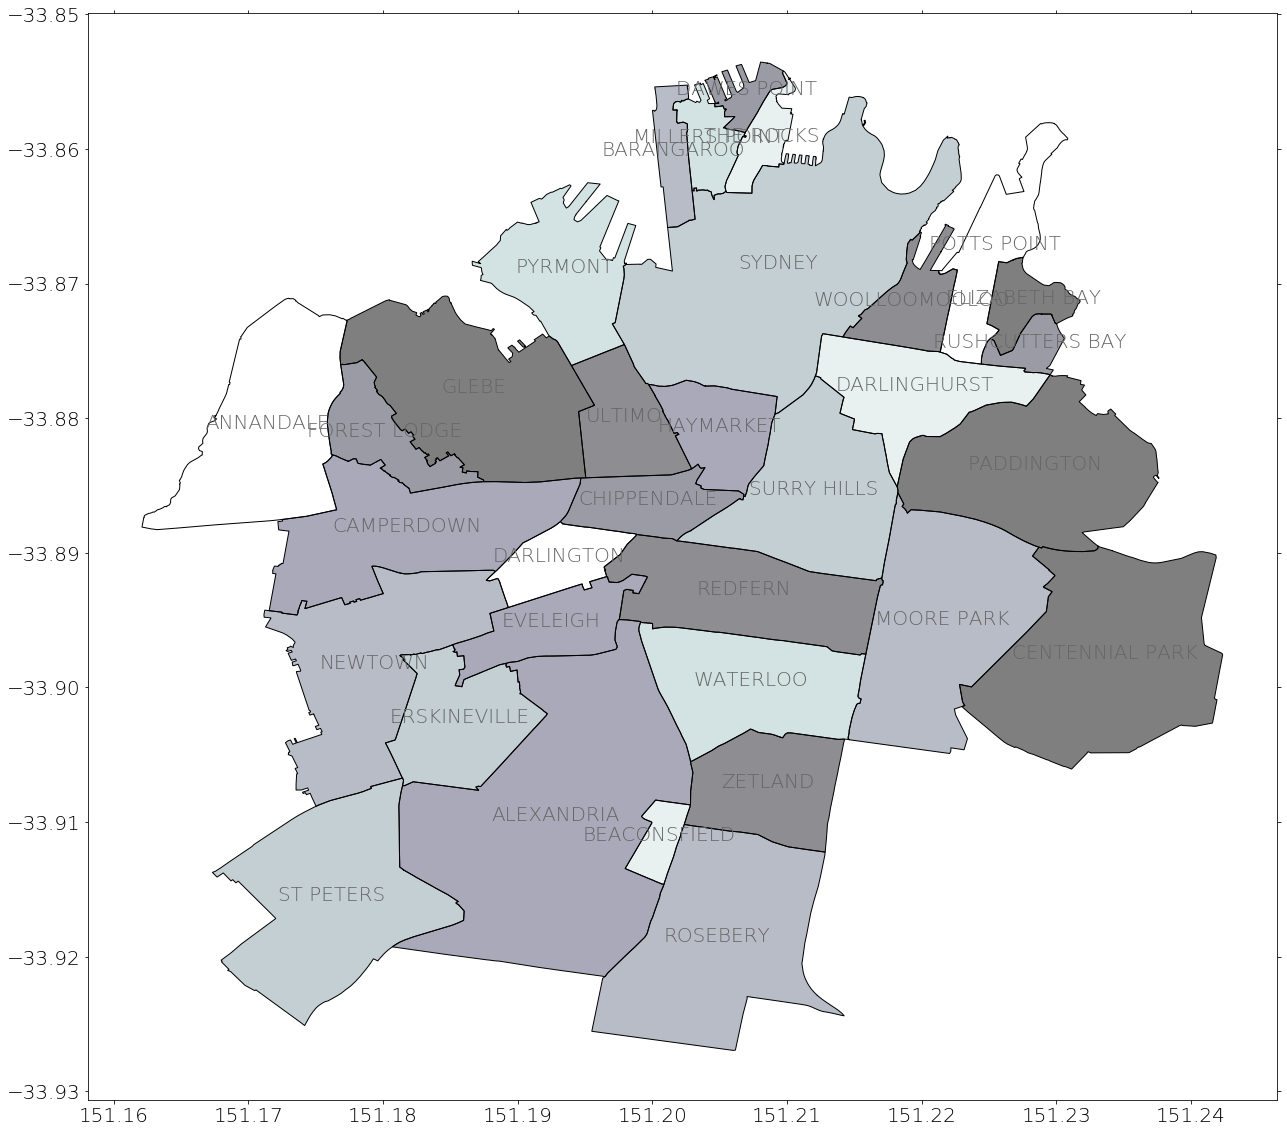

In [10]:
ax = syd_suburbs.plot(cmap='bone')


for idx, row in syd_suburbs.iterrows():
    plt.annotate(s=row.NSW_LOCA_2, 
                 xy=tuple(row.centroid.coords)[0],
                 horizontalalignment='center')

## Sale Price 

### All
From {{min_date}} to {{max_date}}


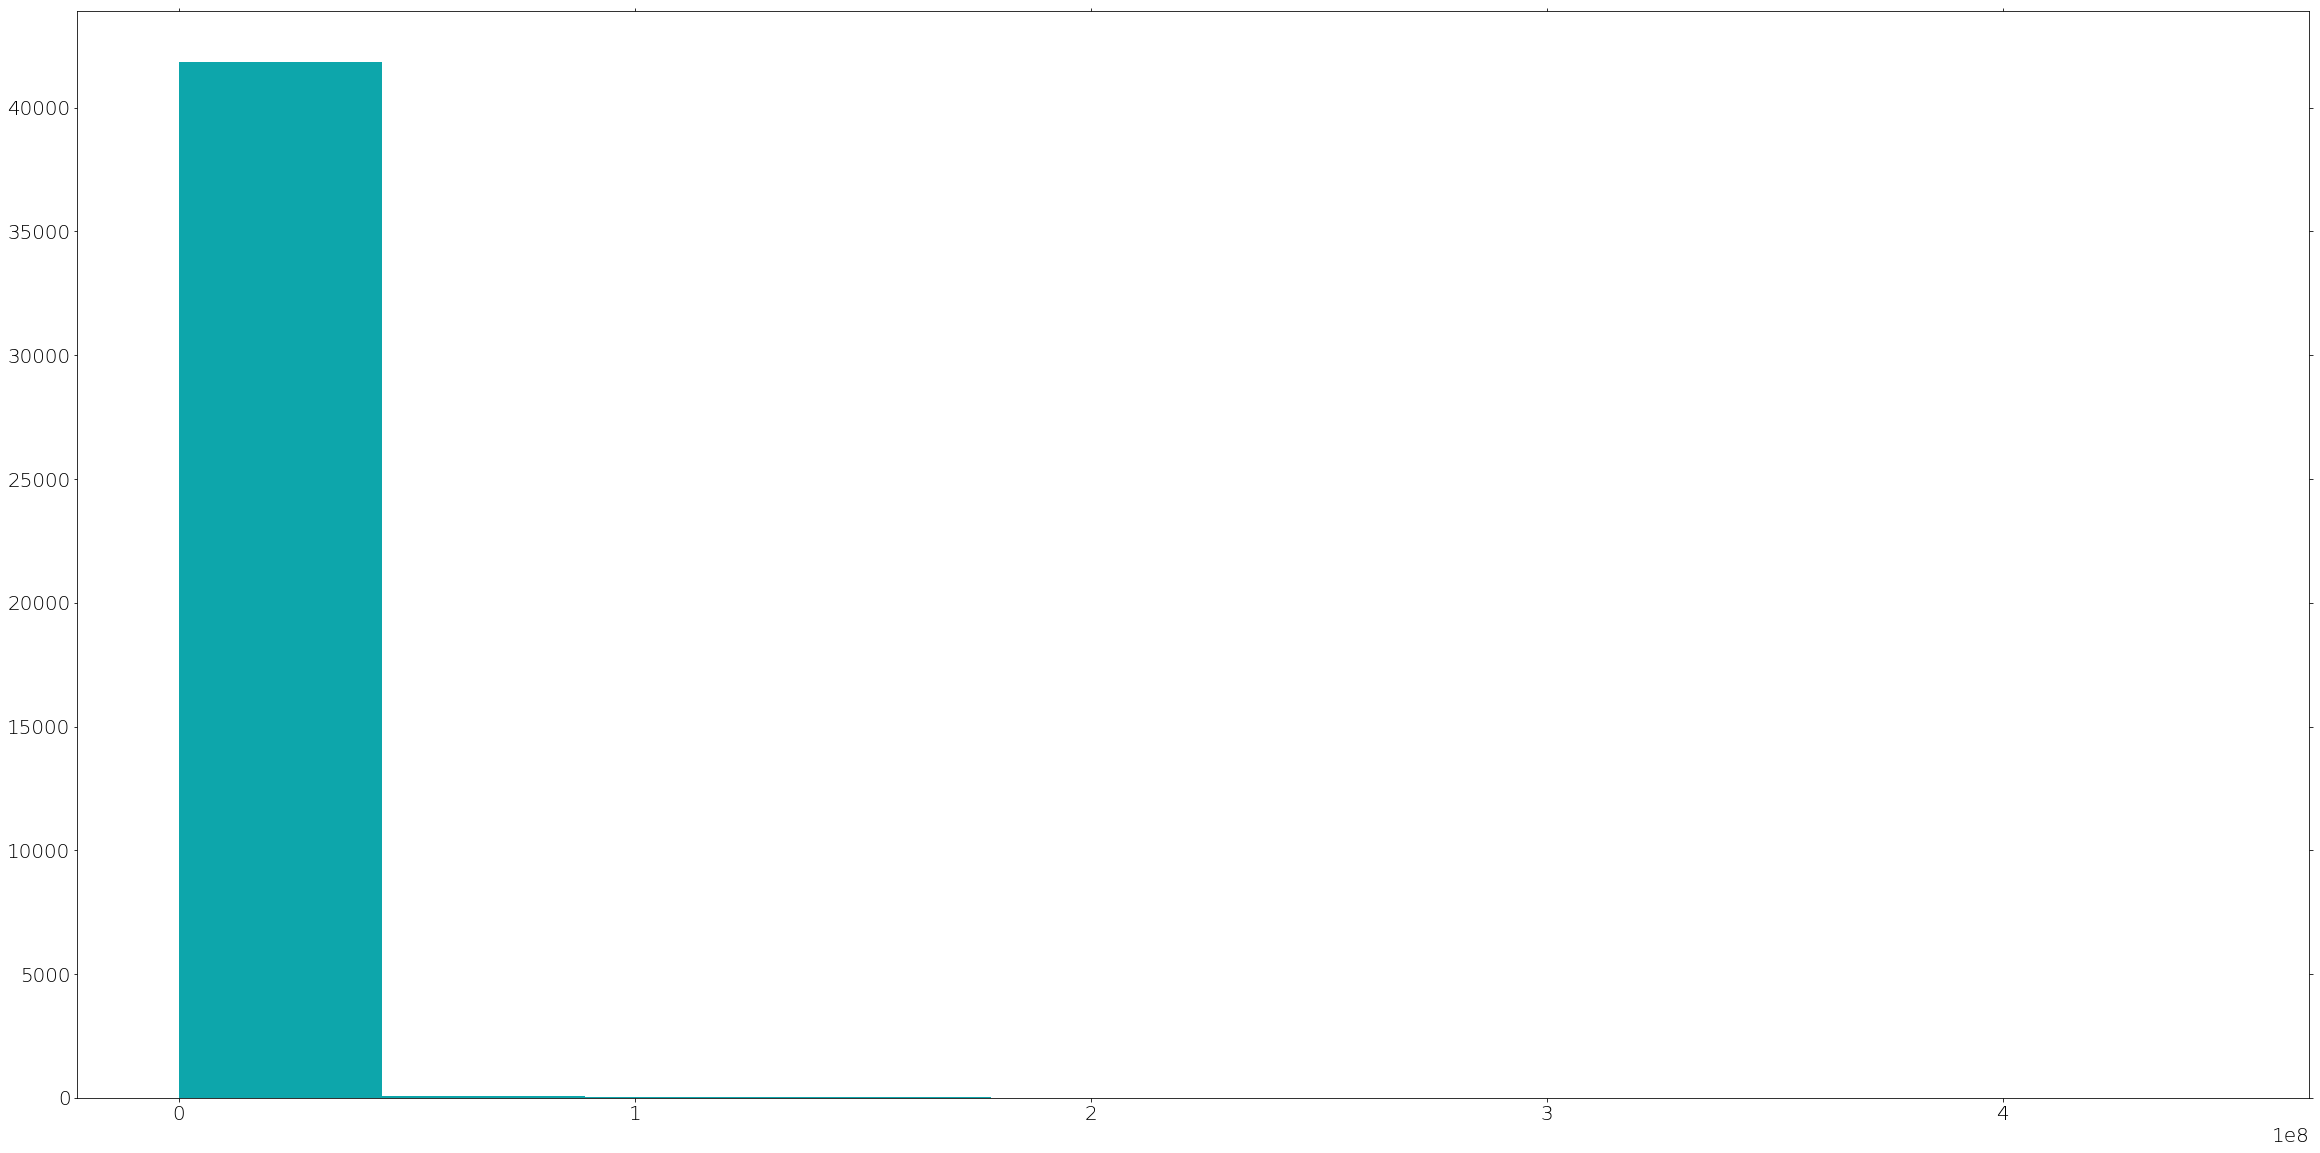

In [11]:
plt.hist(df['SALE PRICE'], color=(0.05, 0.65, 0.67, 1) )
plt.show()

### Sales under $2.5 million (1 bin = 100,000)
From {{min_date}} to {{max_date}}

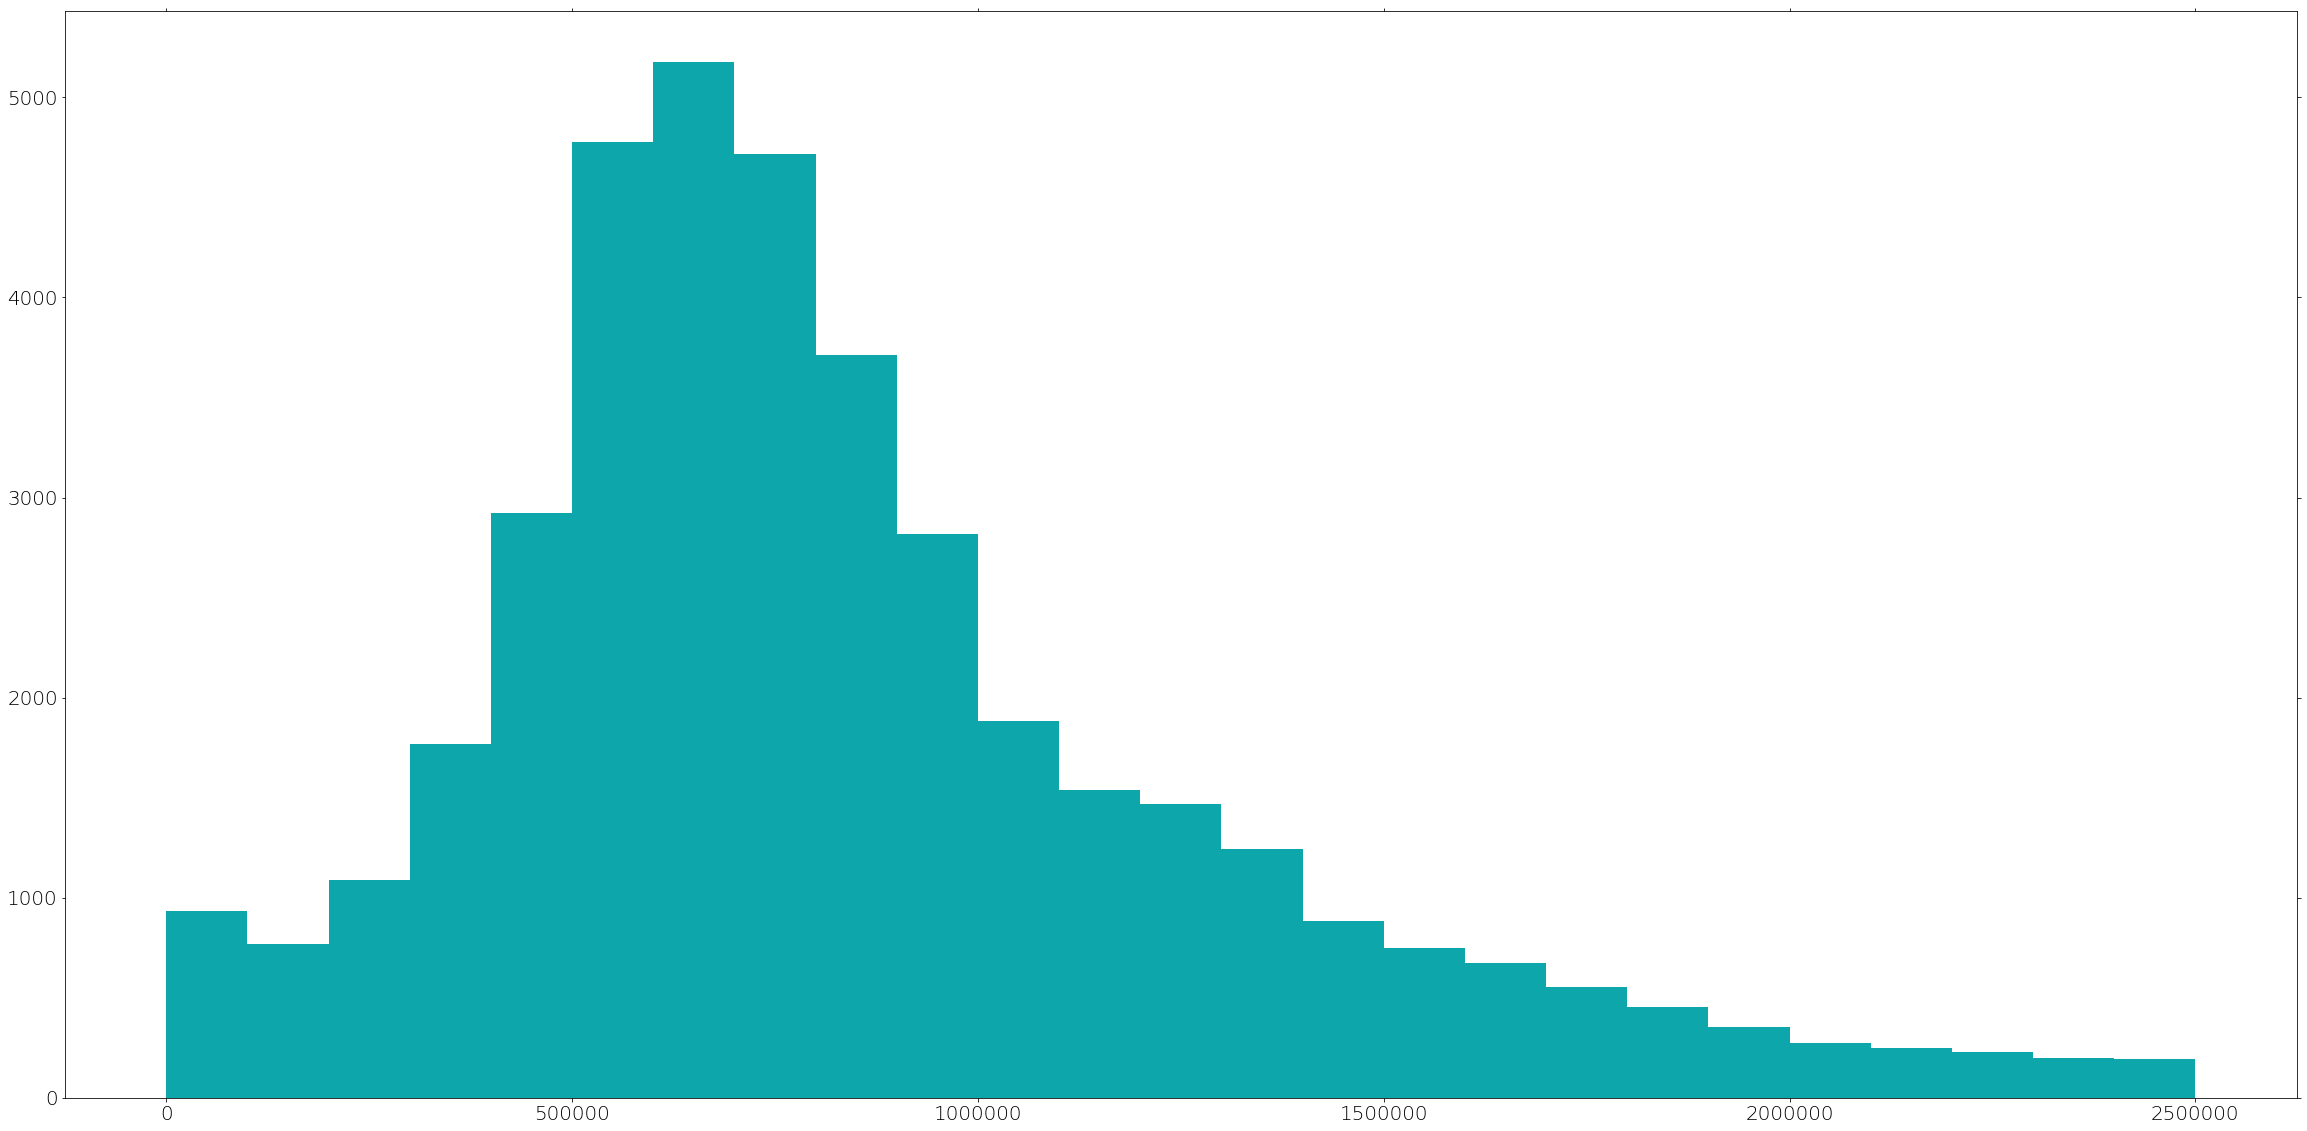

In [12]:
plt.hist(df['SALE PRICE'][df["SALE PRICE"] <= 2500000], bins=25, color=(0.05, 0.65, 0.67, 1))
plt.show()

### Sales under $2.5 million (1 bin = 10,000)
From {{min_date}} to {{max_date}}

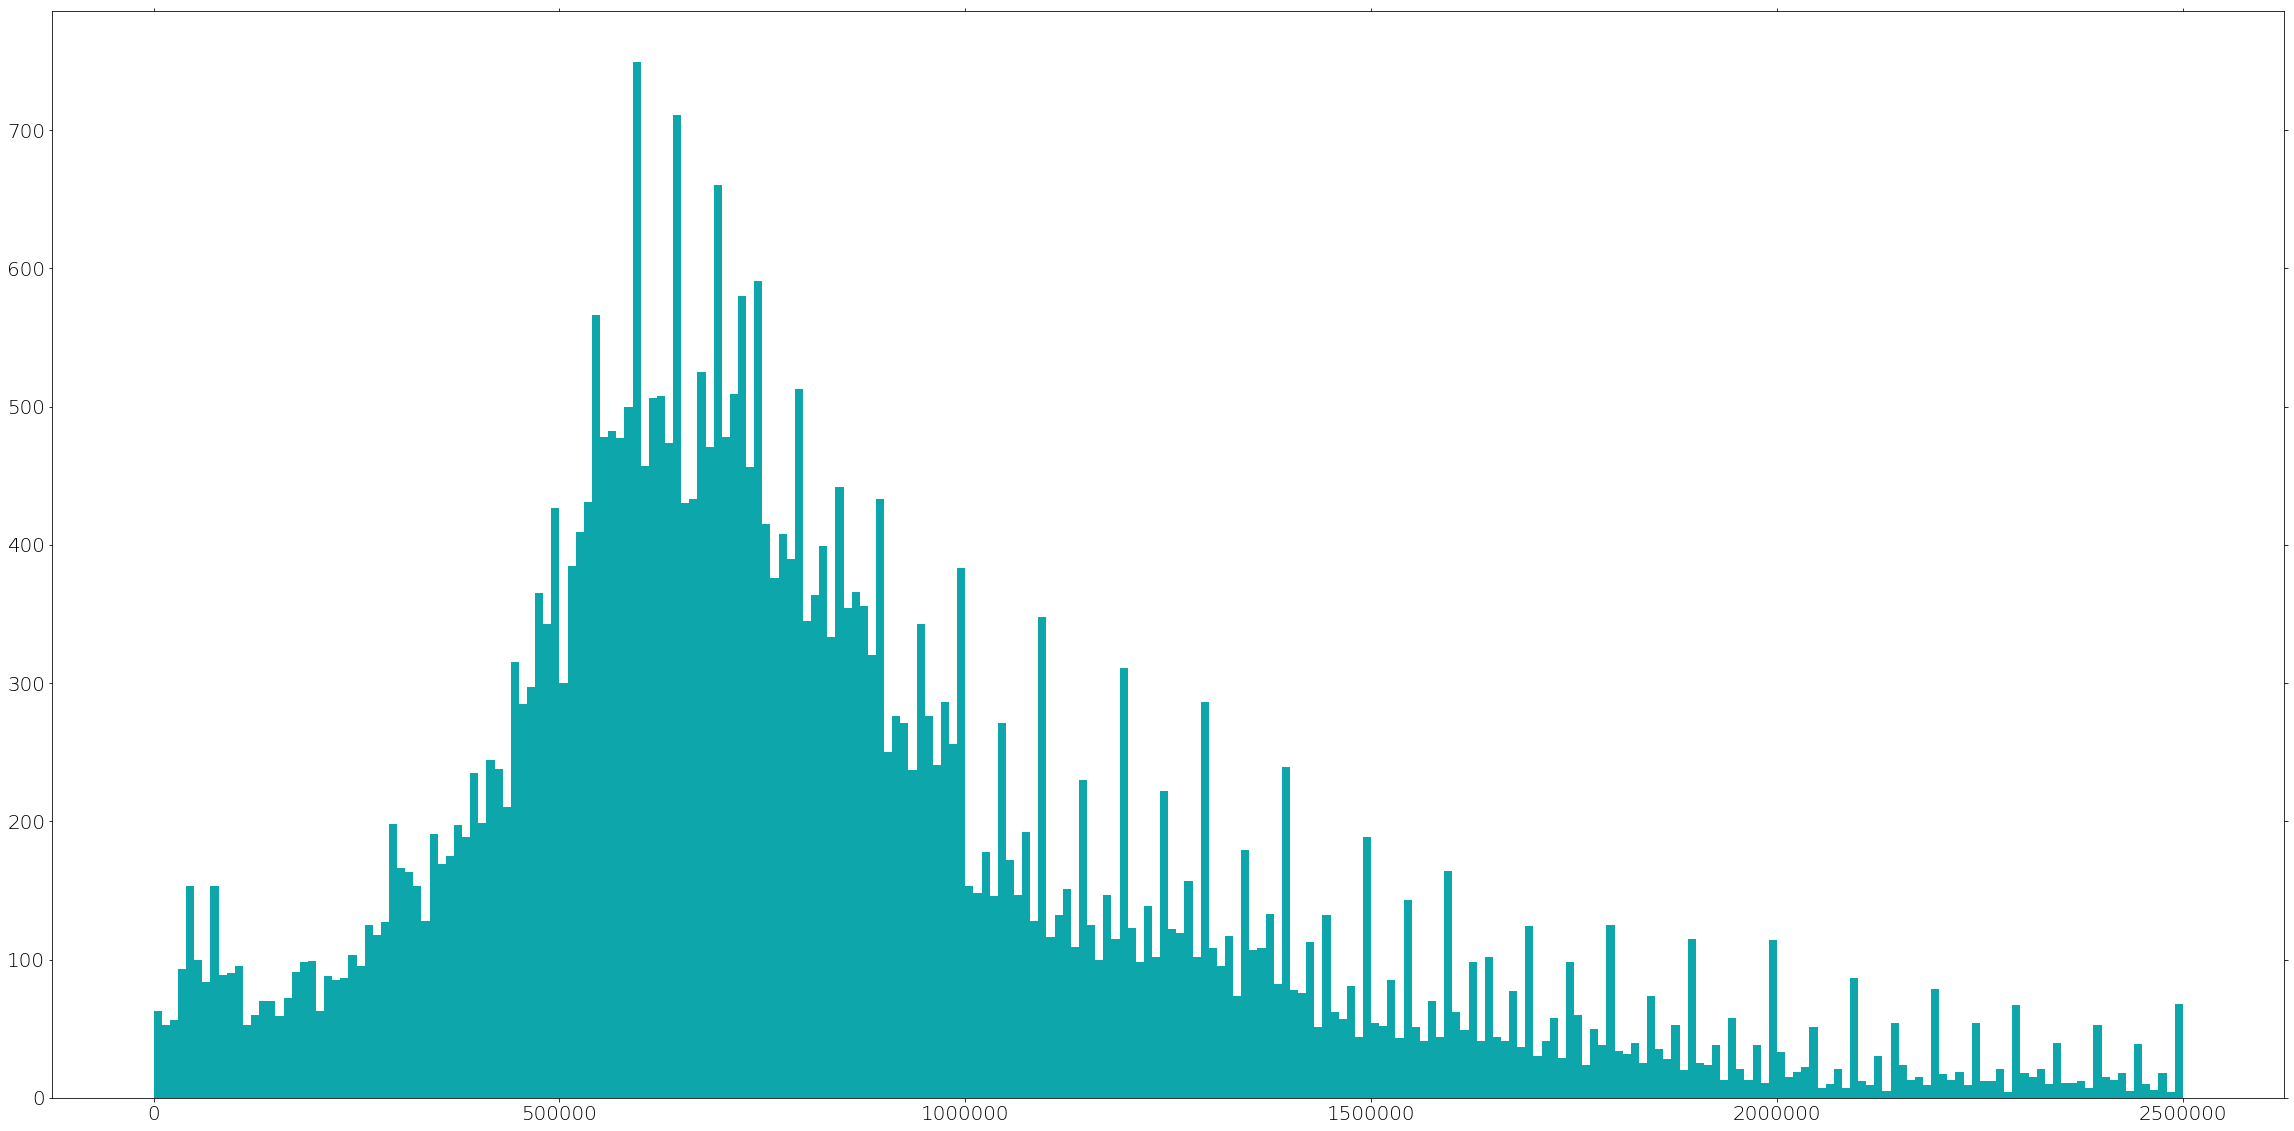

In [13]:
plt.hist(df['SALE PRICE'][df["SALE PRICE"] <= 2500000], bins=250, color=(0.05, 0.65, 0.67, 1))

plt.show()

### Sales under $2.5 million (1 bin = 1,000)
From {{min_date}} to {{max_date}}

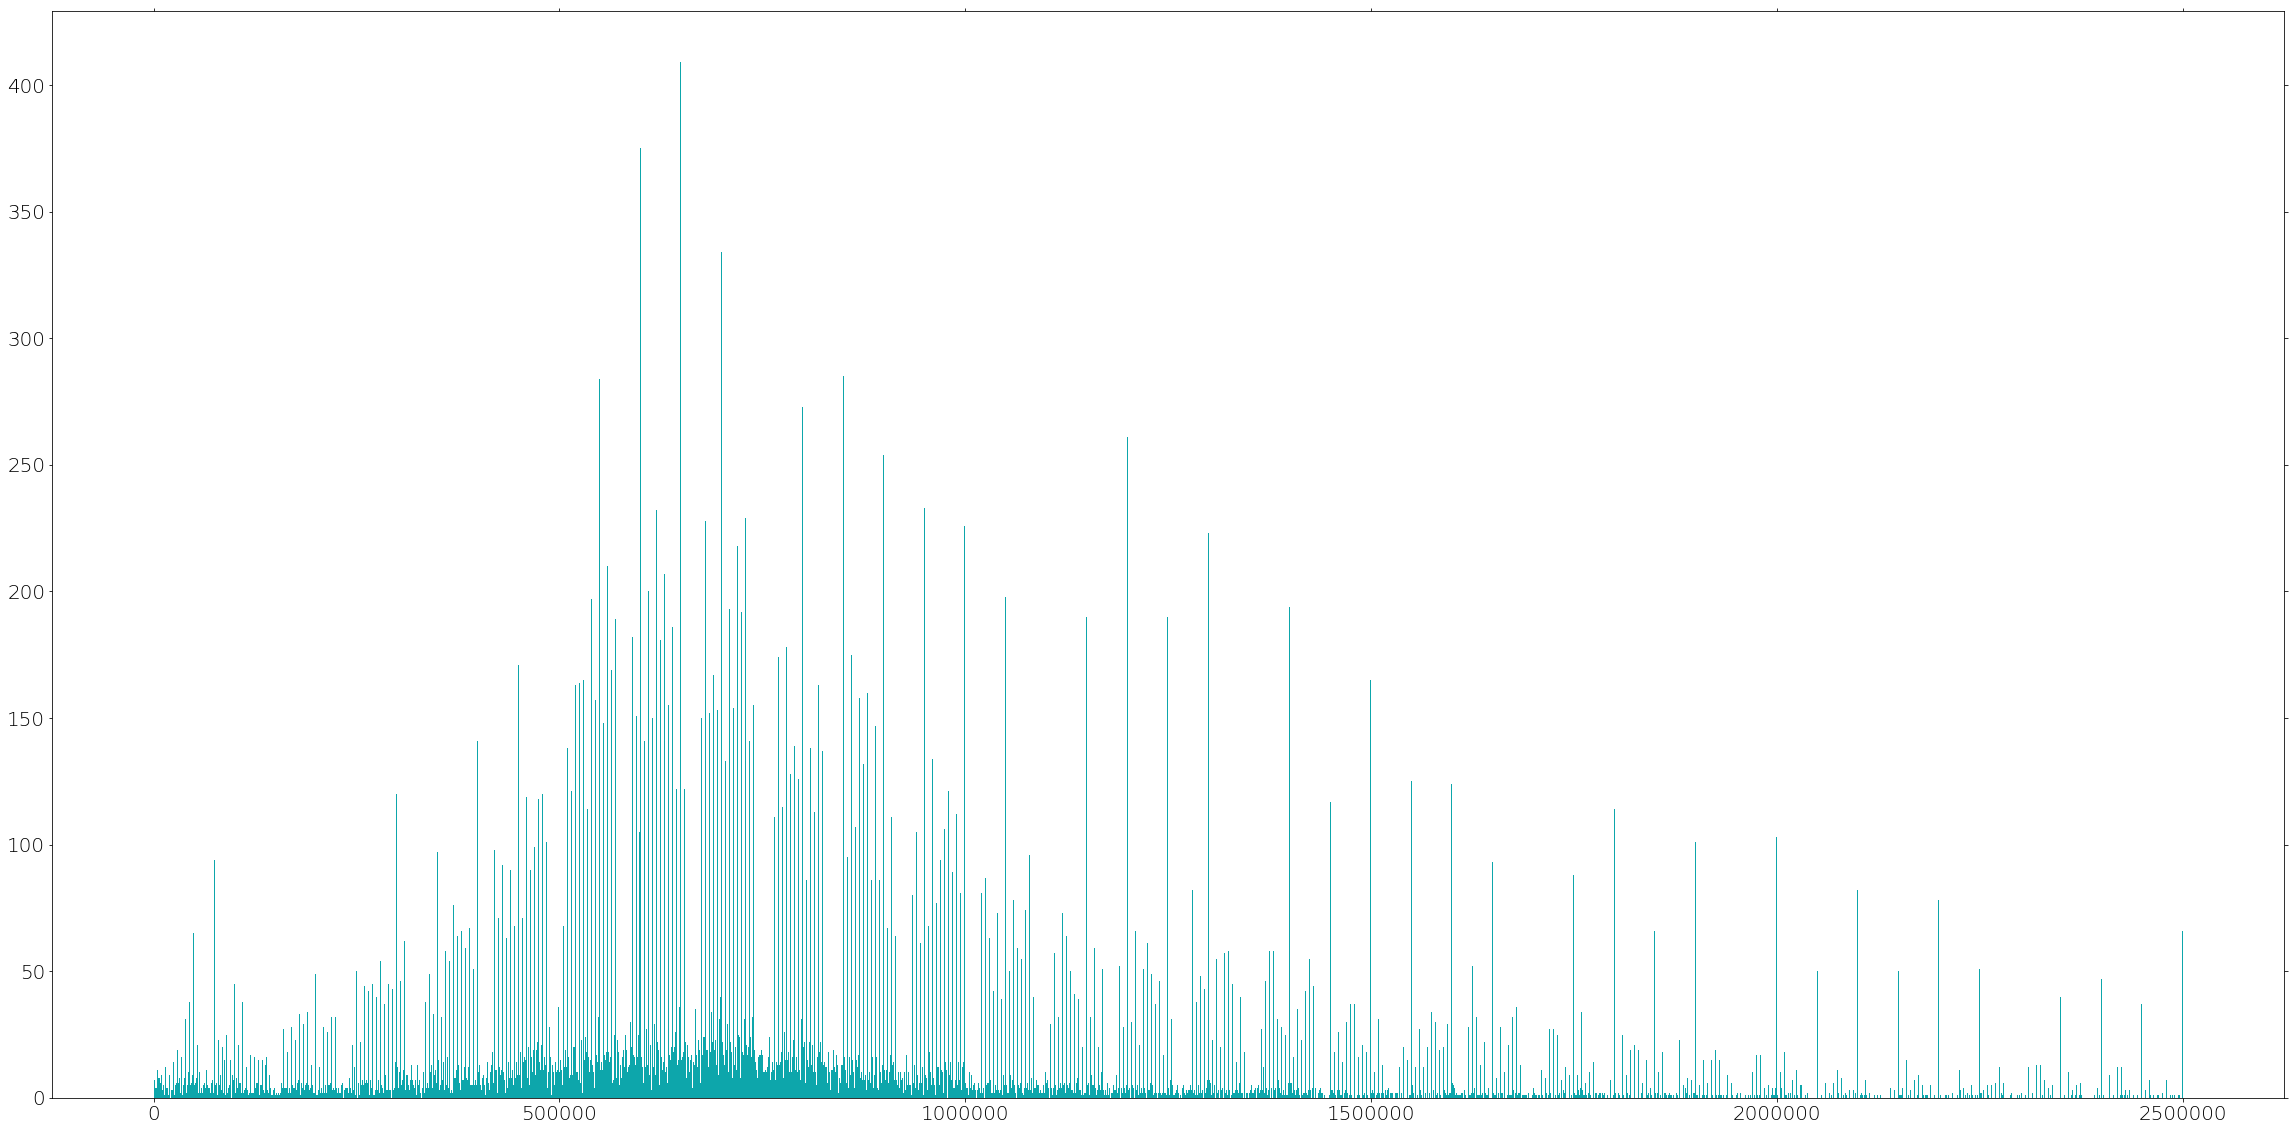

In [14]:
plt.hist(df['SALE PRICE'][df["SALE PRICE"] <= 2500000], bins=2500, color=(0.05, 0.65, 0.67, 1))
plt.show()

### Sales under $2.5 million (1 bin = 100)
From {{min_date}} to {{max_date}}

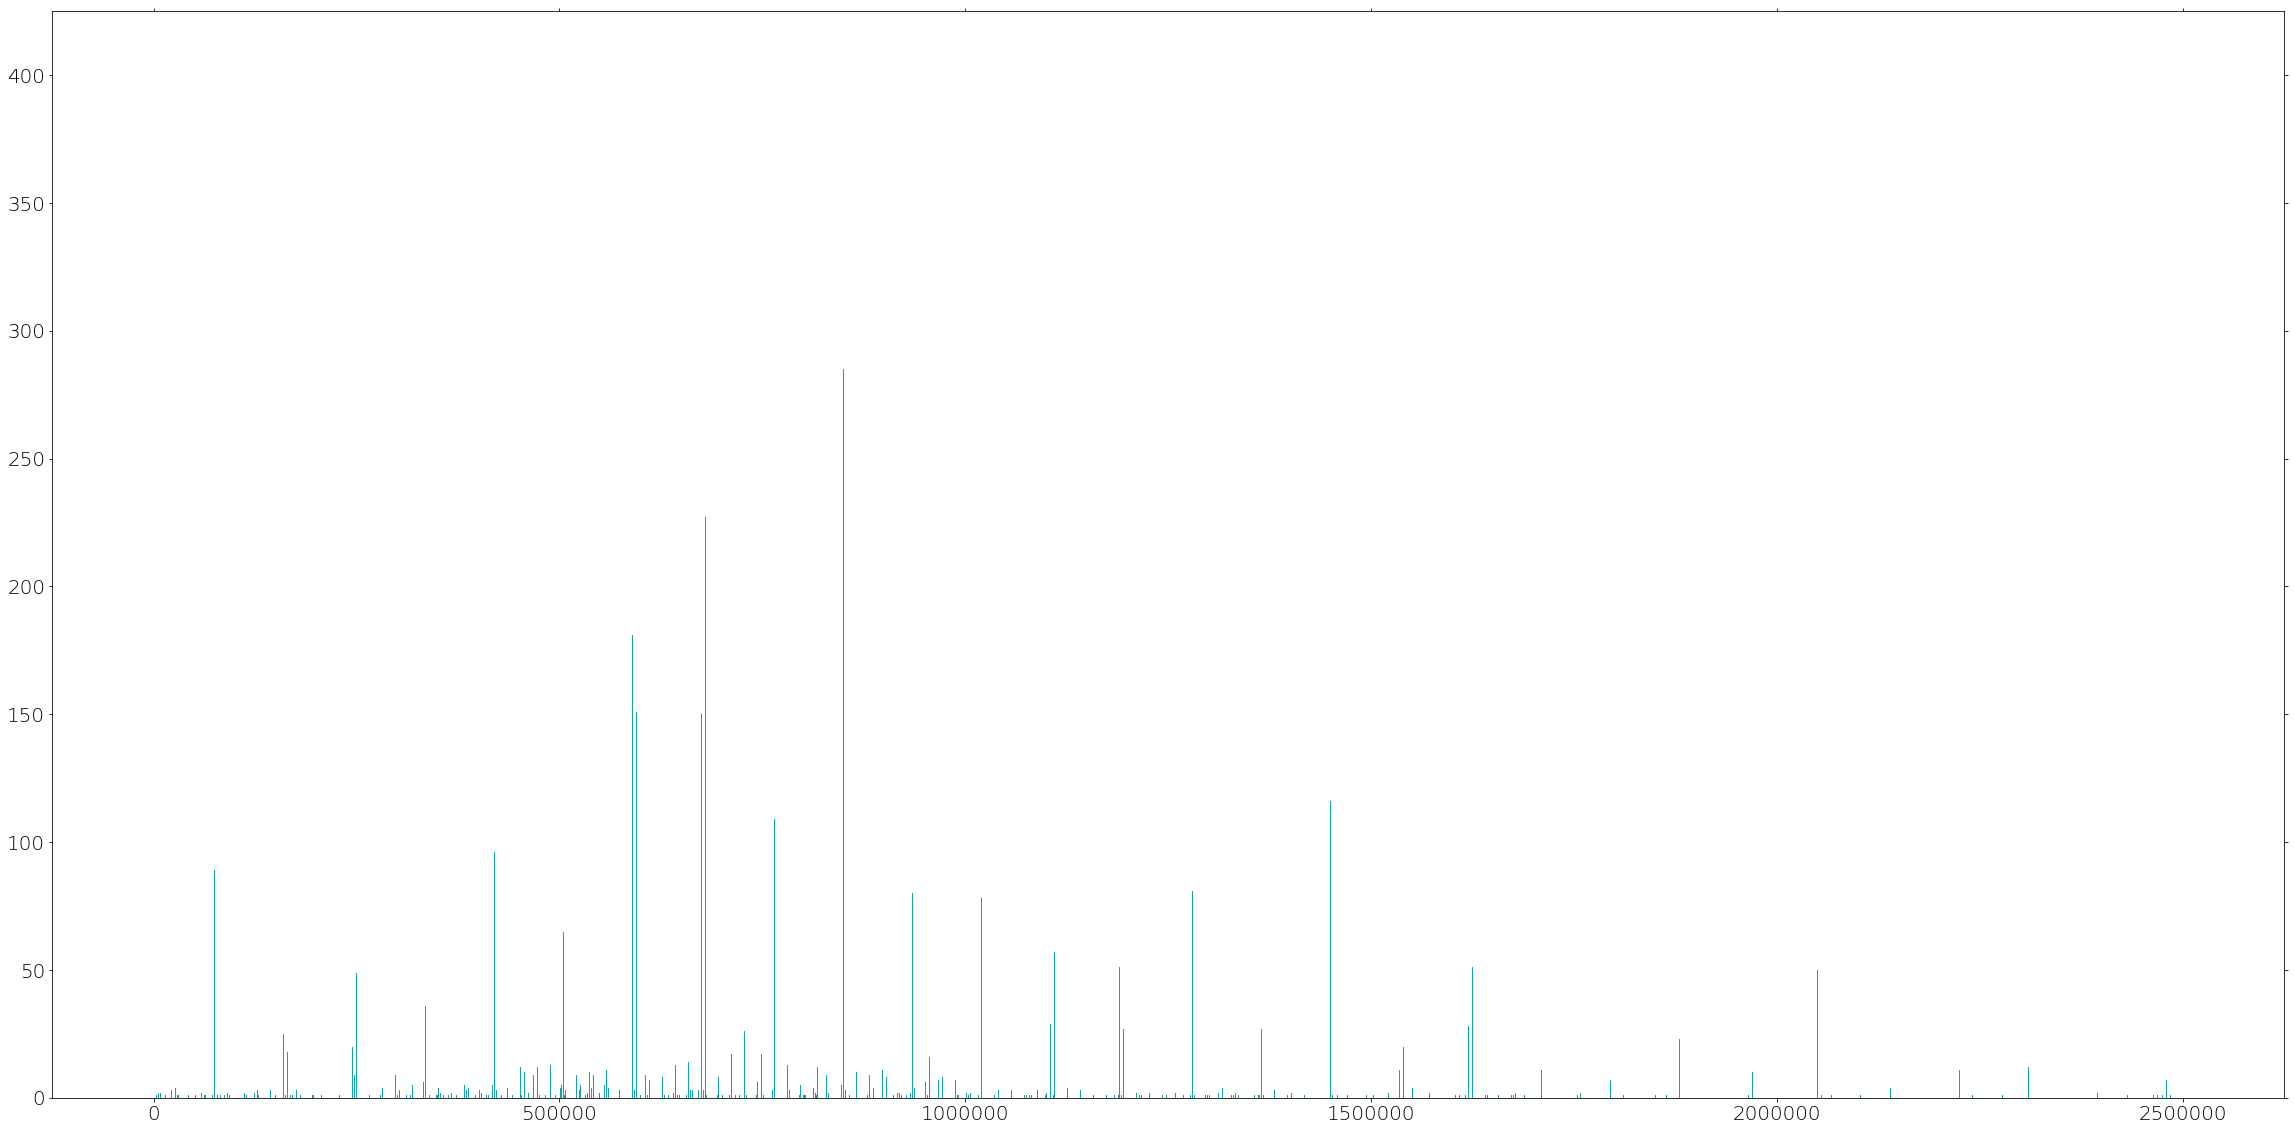

In [15]:
plt.hist(df['SALE PRICE'][df["SALE PRICE"] <= 2500000], bins=25000, color=(0.05, 0.65, 0.67, 1))
plt.show()

### Sales between 700,000 and 800,000 (1 bin = 100)
From {{min_date}} to {{max_date}}

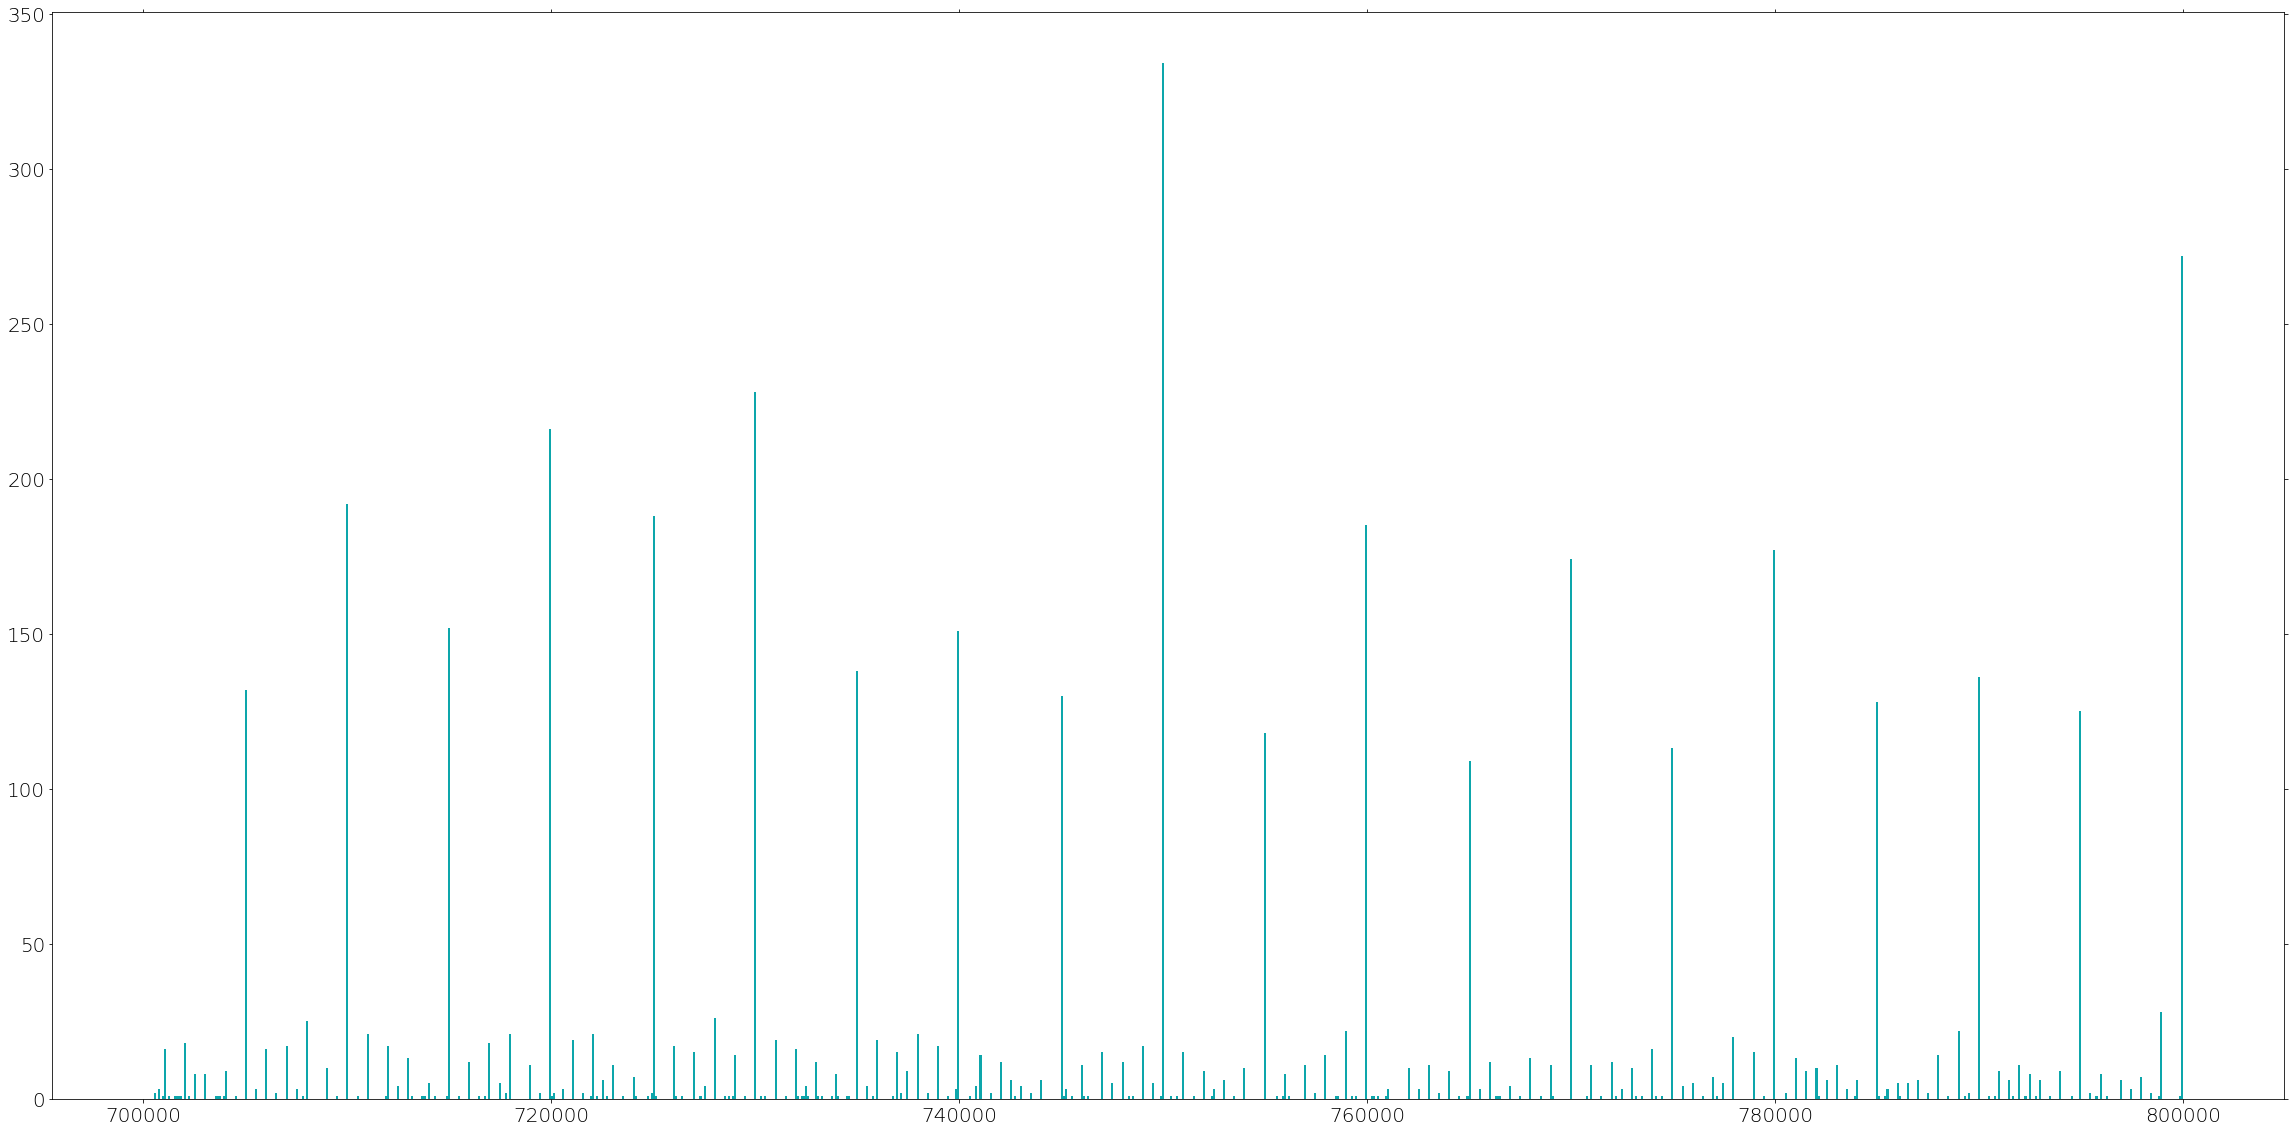

In [16]:
plt.hist(df['SALE PRICE'][700000 < df["SALE PRICE"]][df["SALE PRICE"] <= 800000], bins=1000, color=(0.05, 0.65, 0.67, 1))
plt.show()

## Time

### Day of the week (Monday to Sunday)

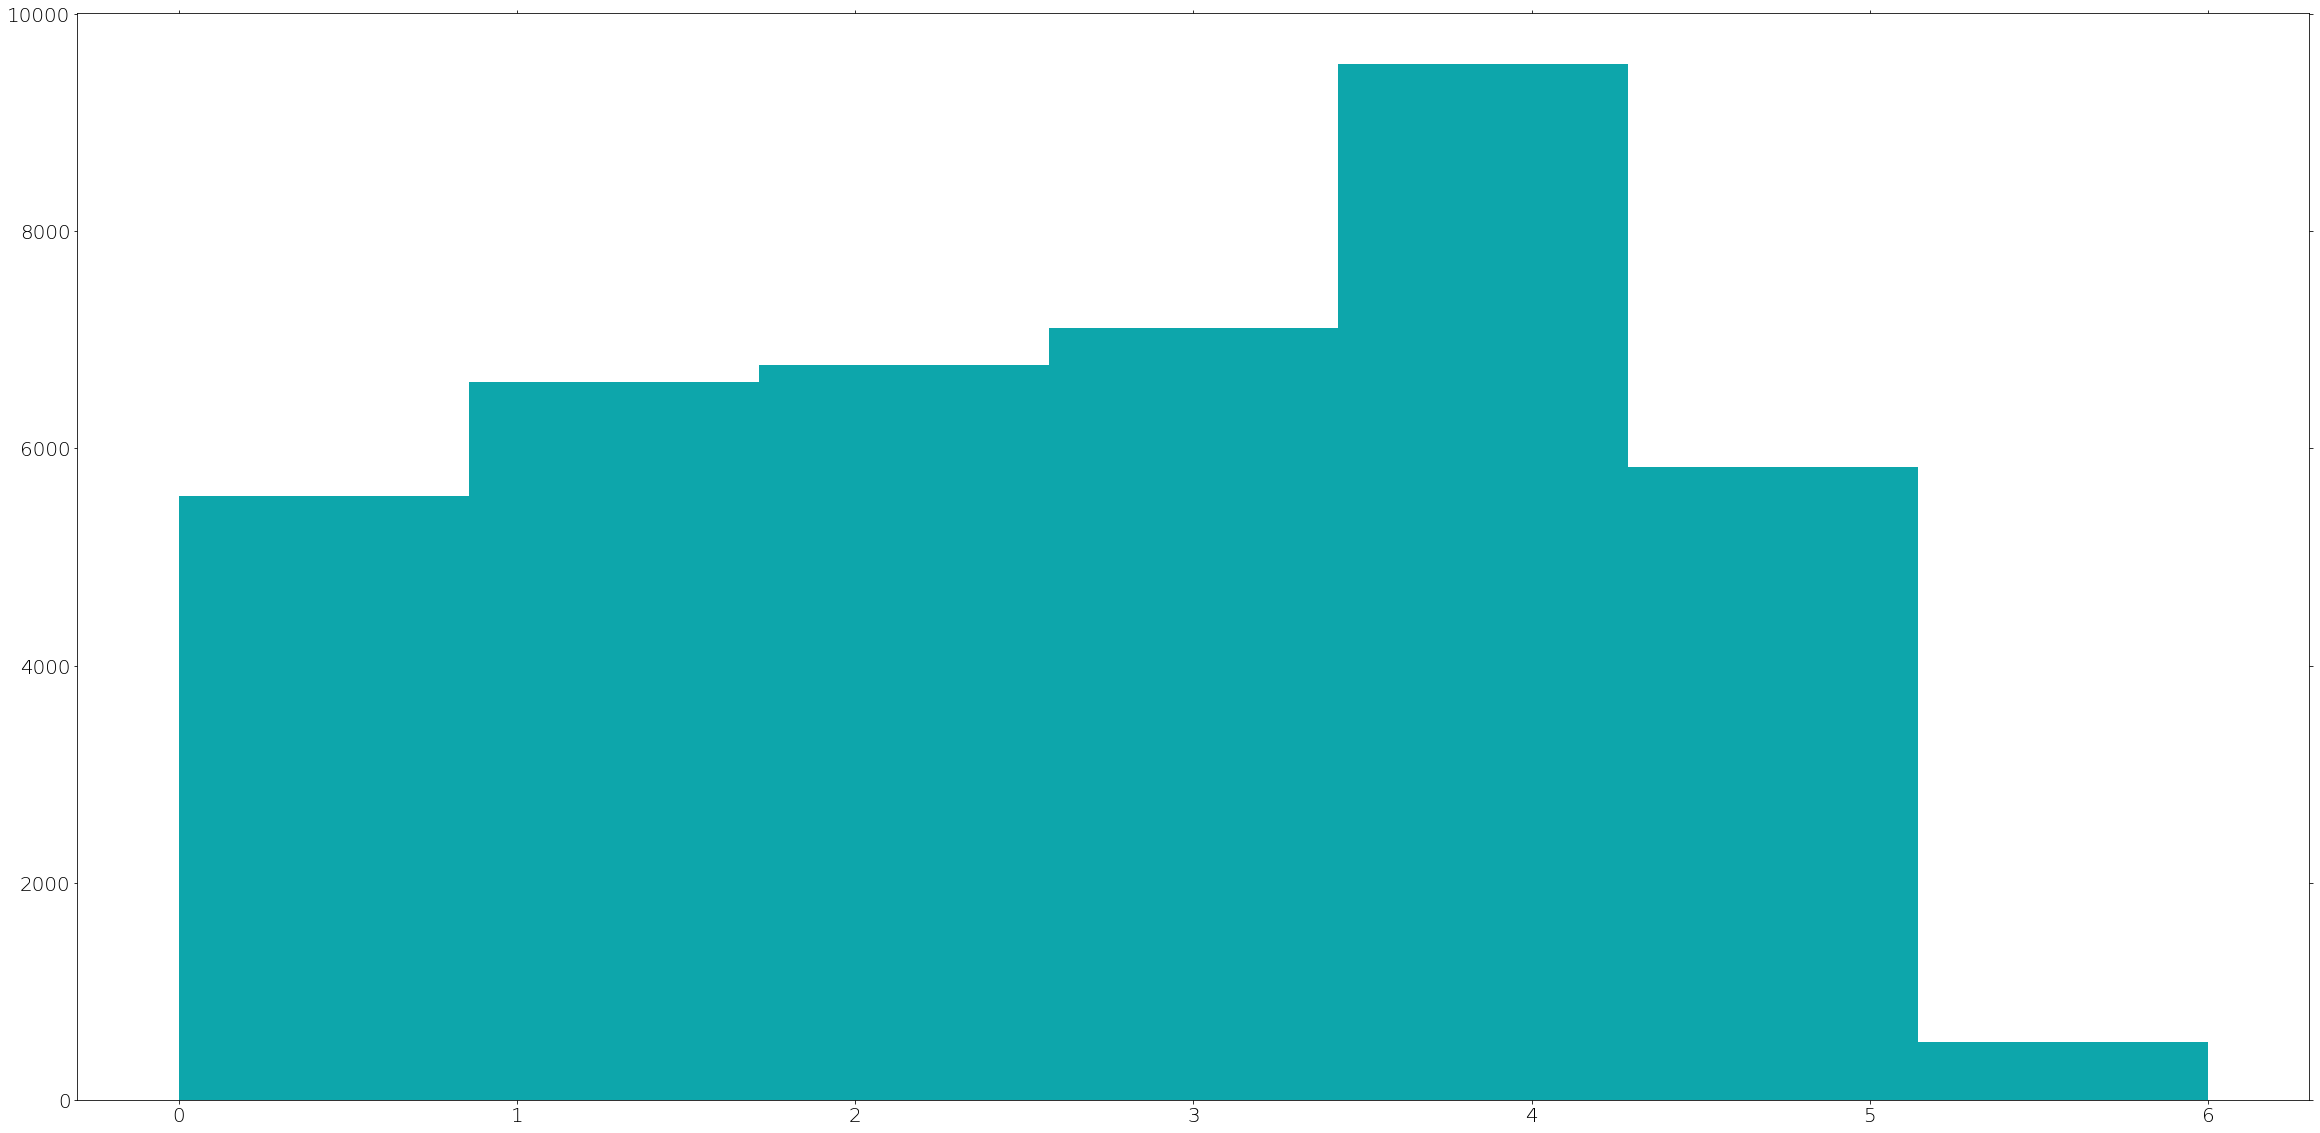

In [17]:
plt.hist(df["WEEKDAY"], bins=7, color=(0.05, 0.65, 0.67, 1));

### Day of the week boxplot

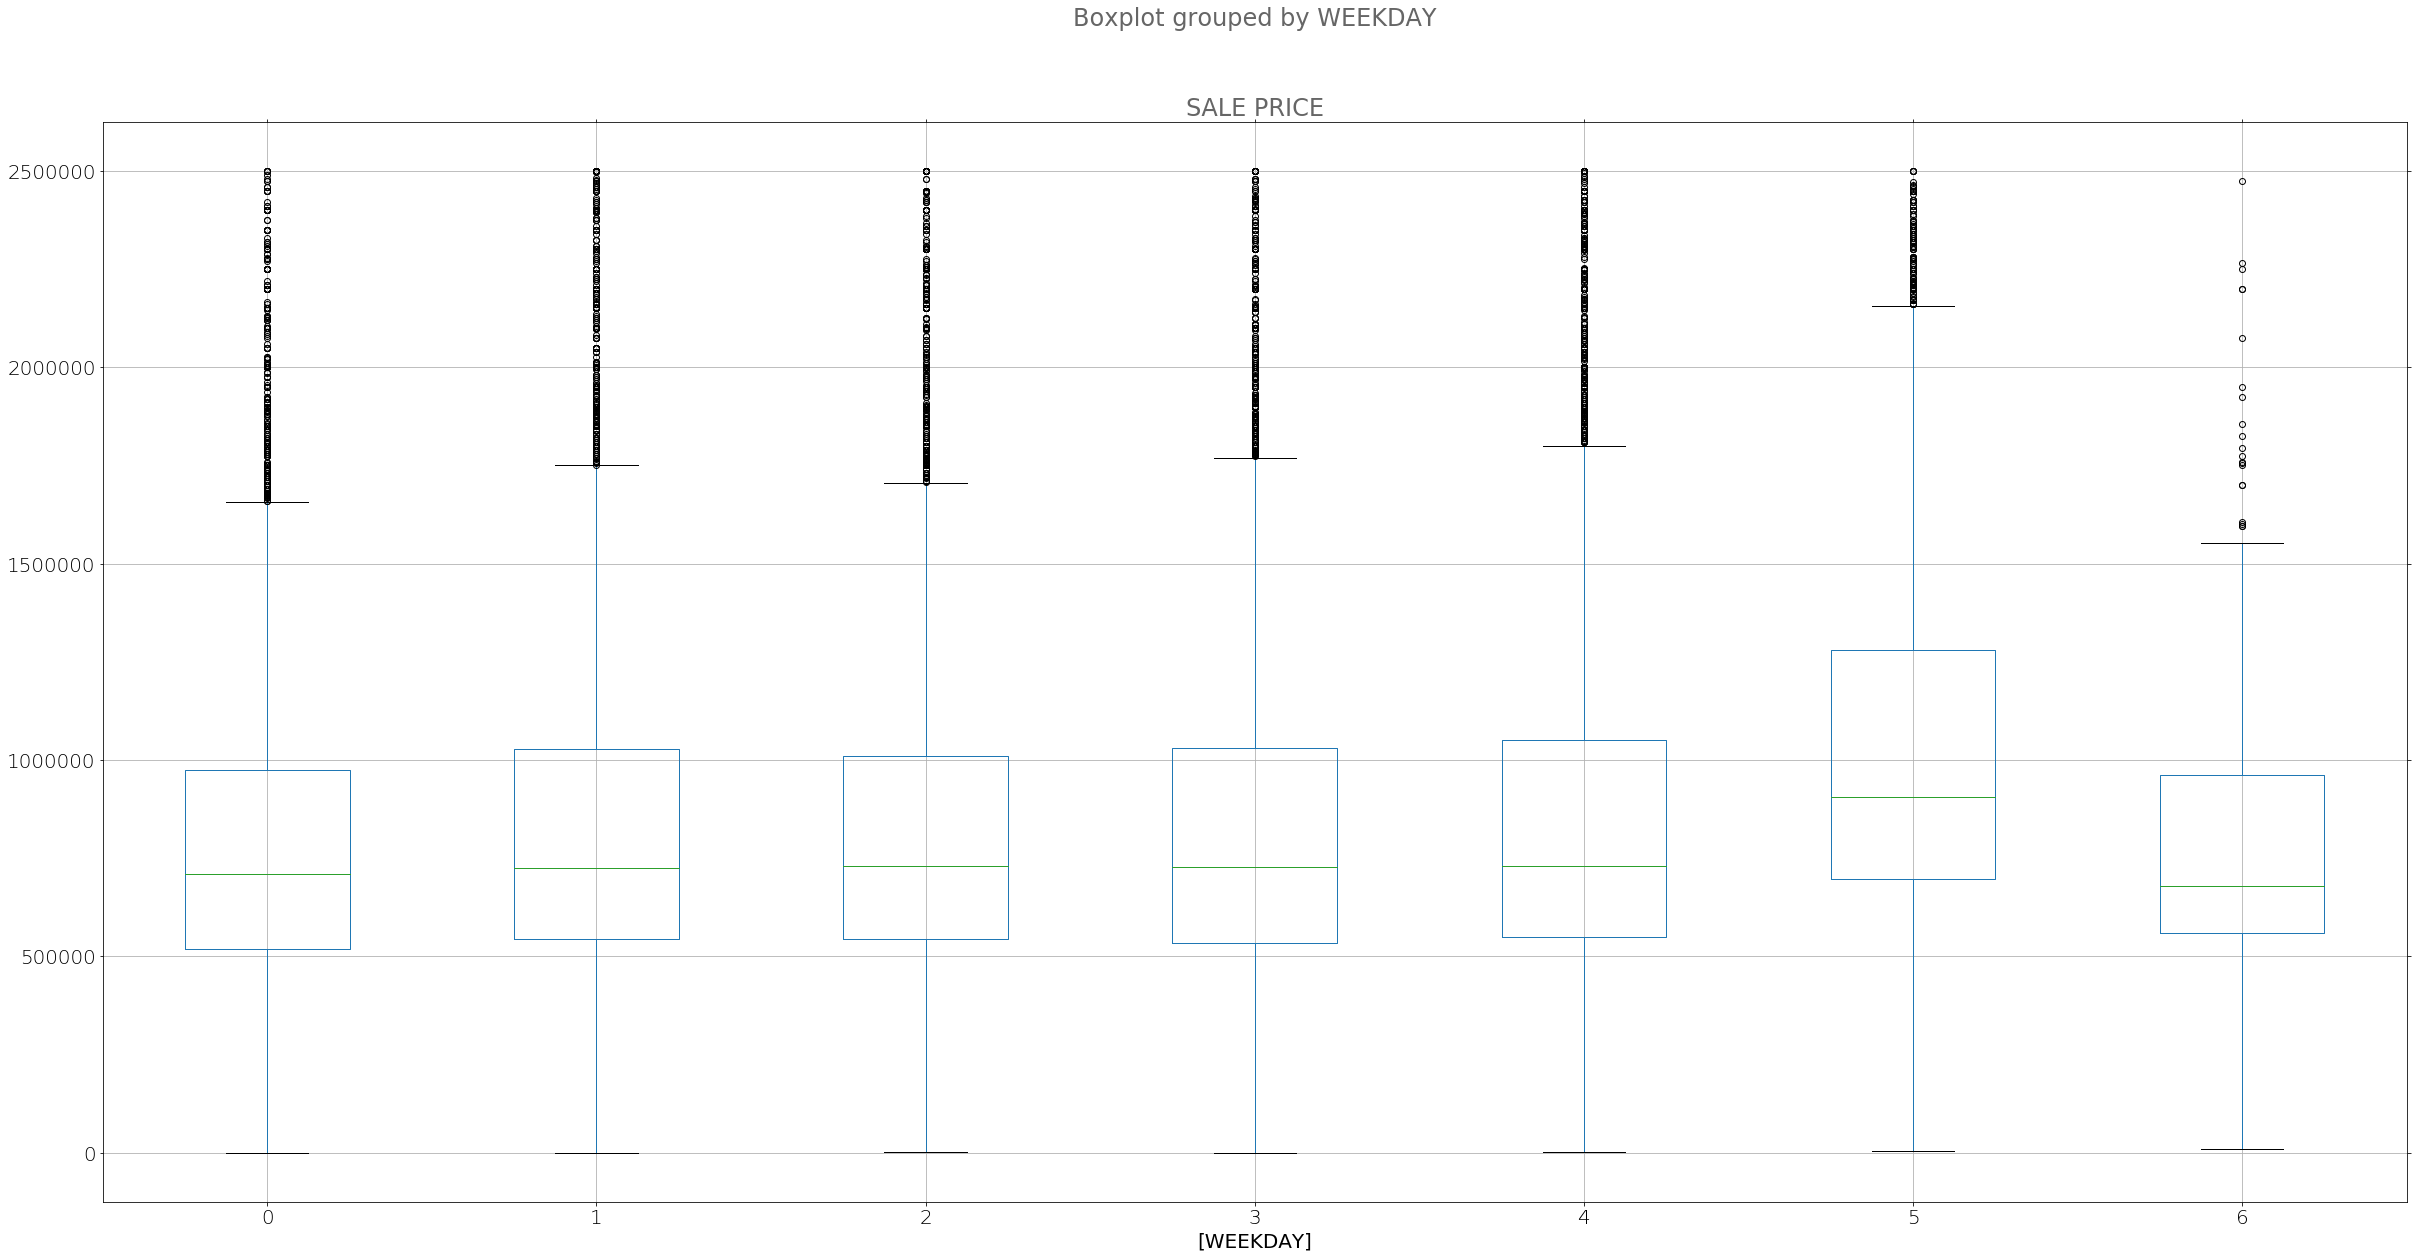

In [18]:
weekday_box_plot = df[['SALE PRICE', 'WEEKDAY']][df["SALE PRICE"] <= 2500000].boxplot(by='WEEKDAY');

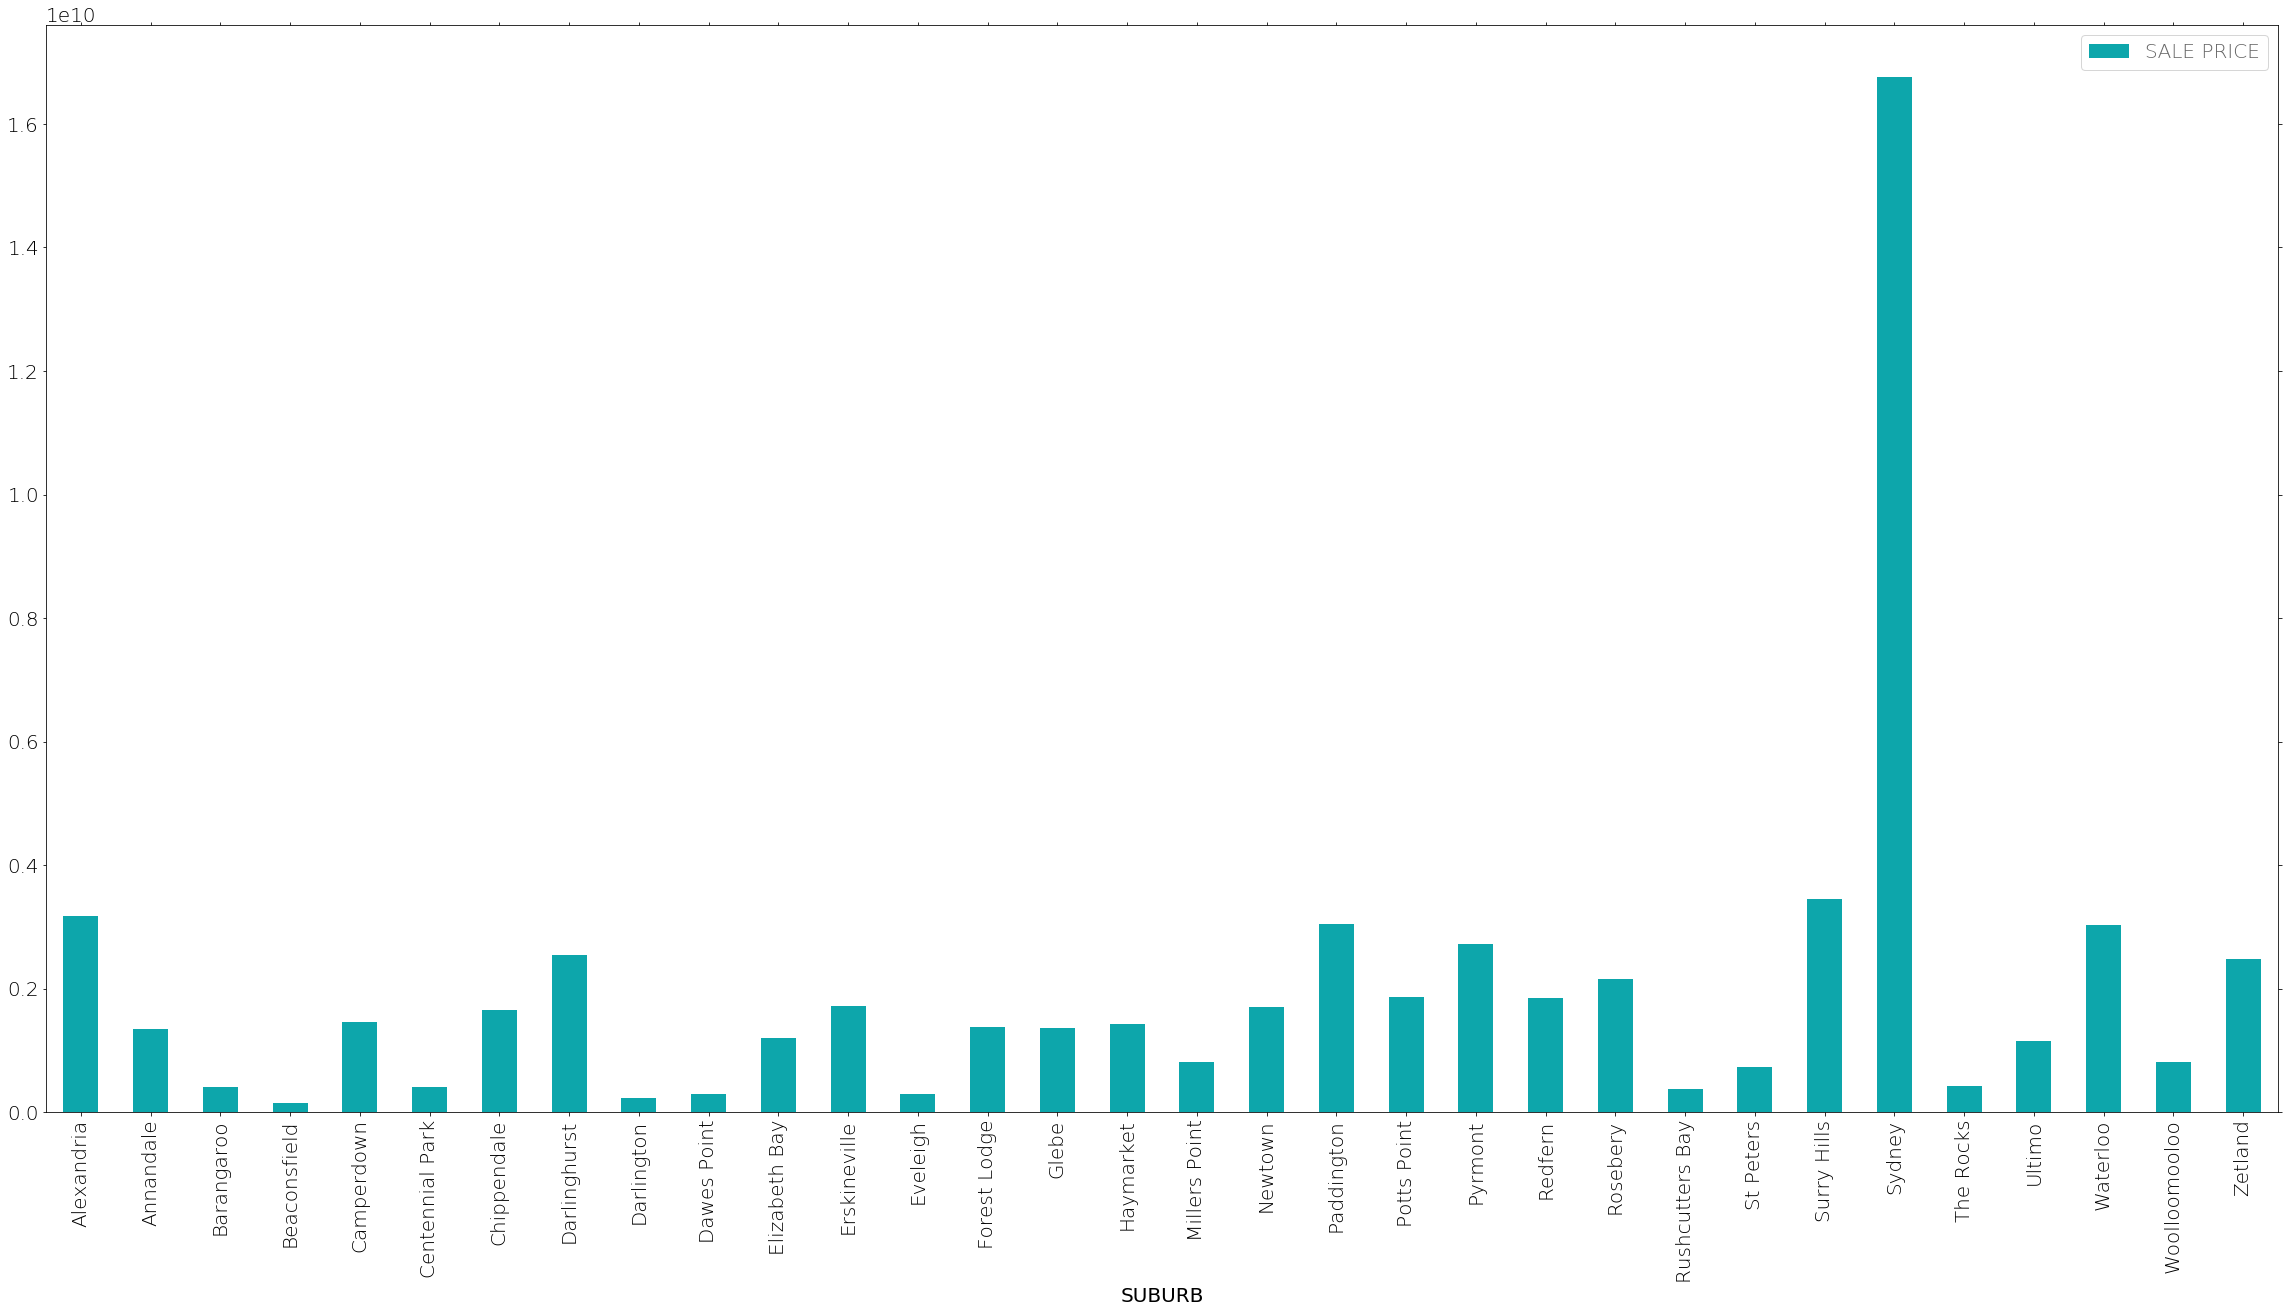

In [19]:
suburb_sum = df[["SALE PRICE", "SUBURB"]].groupby("SUBURB").sum()

suburb_sum.plot.bar(color=(0.05, 0.65, 0.67, 1));

In [20]:
suburb_count = df[["SALE PRICE", "SUBURB"]].groupby("SUBURB").count()

suburb_ave.plot.bar(color=(0.05, 0.65, 0.67, 1));

NameError: name 'suburb_ave' is not defined

### Average price per year

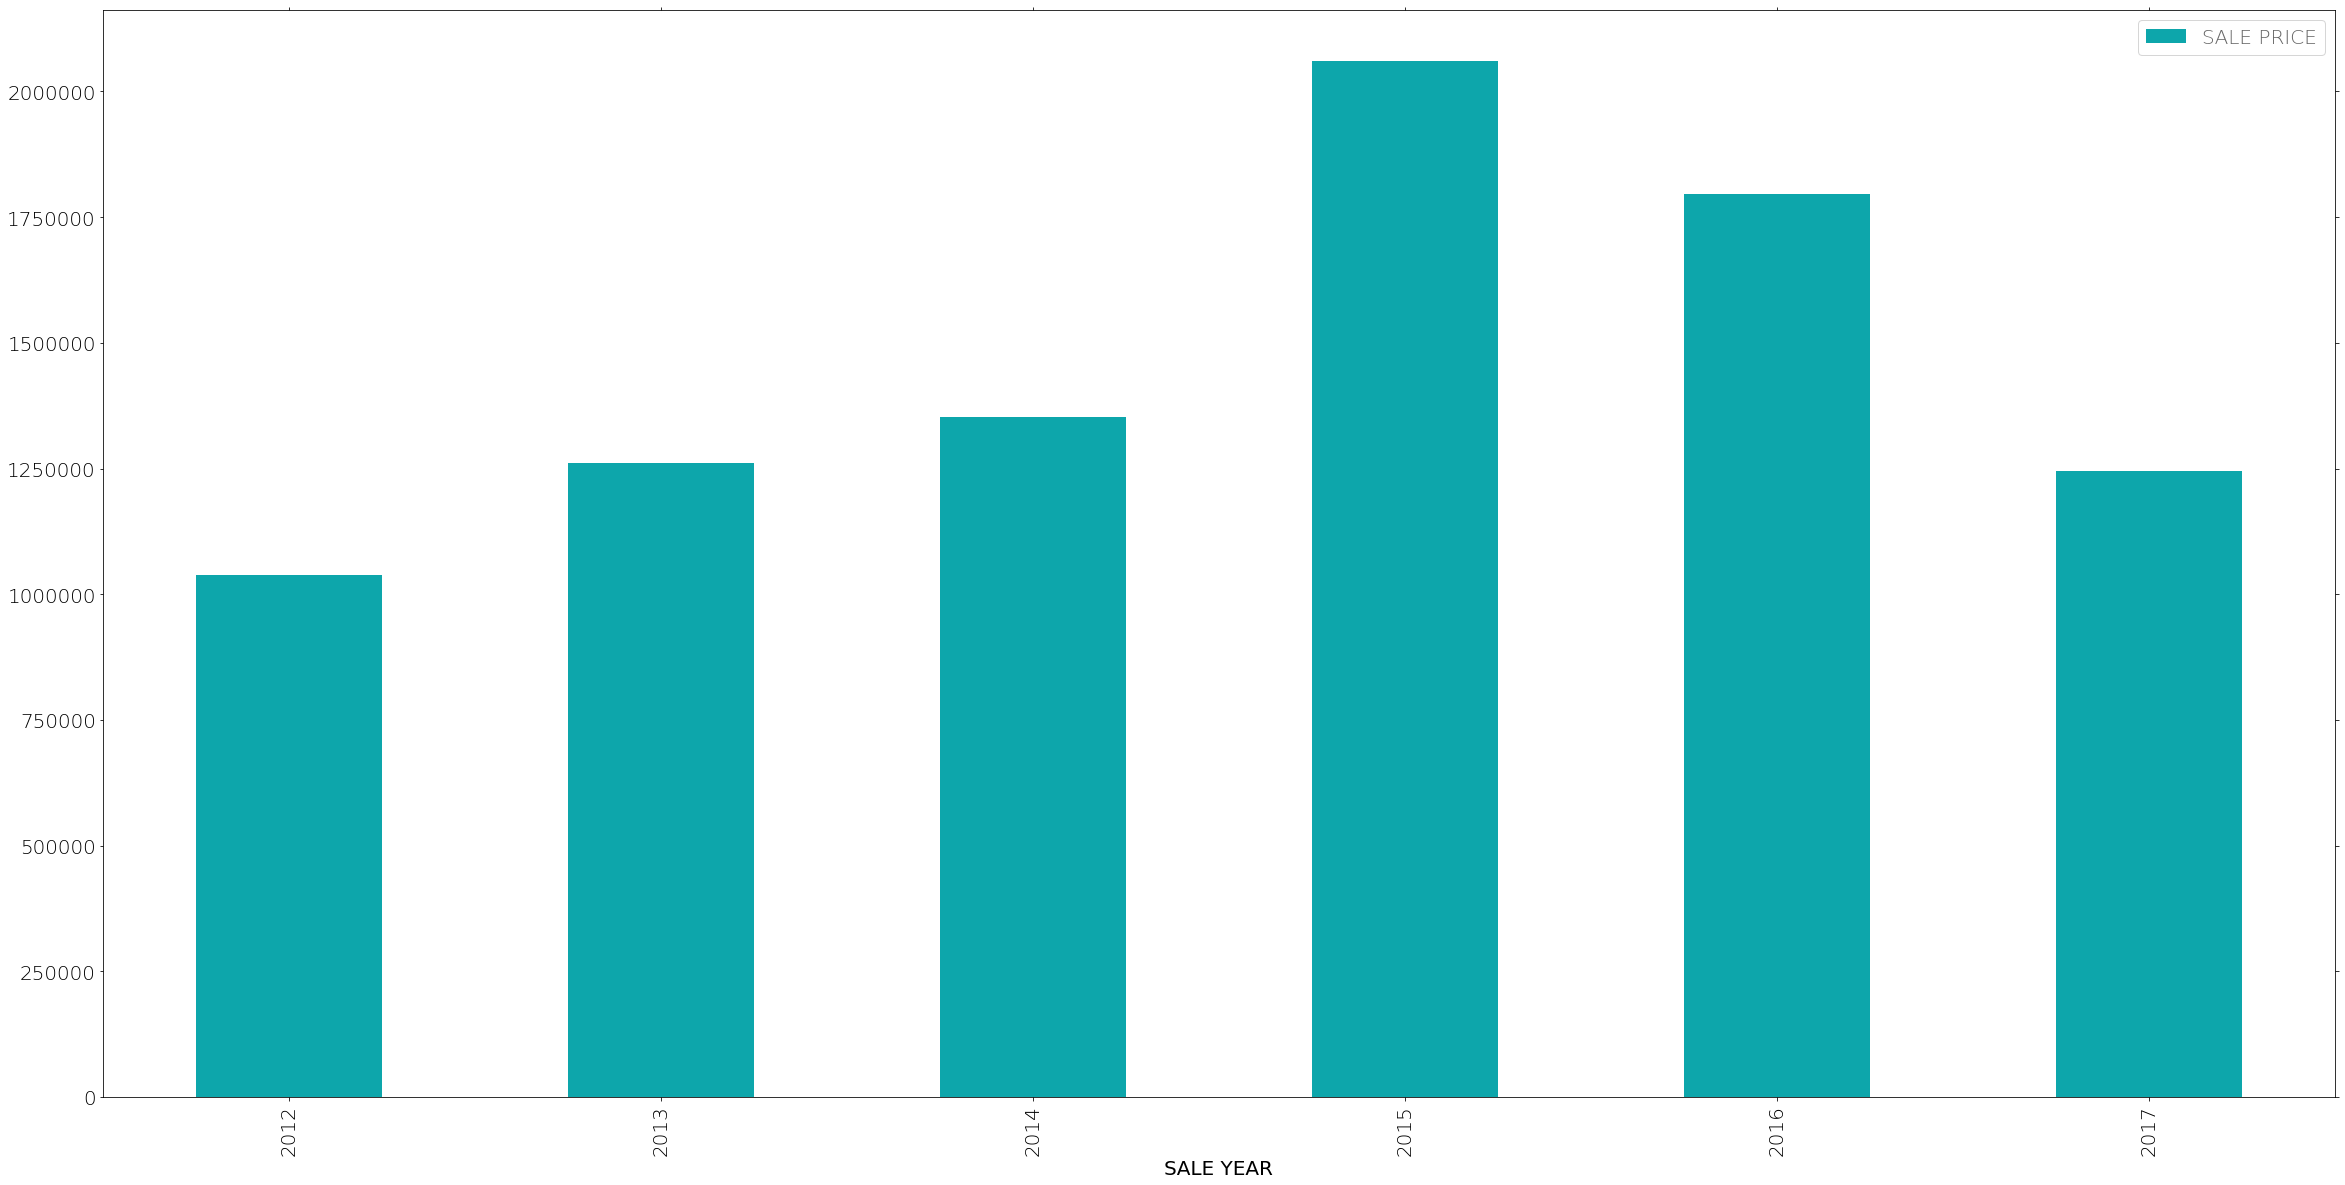

In [21]:
year_ave = df[['SALE YEAR', 'SALE PRICE']].groupby("SALE YEAR").mean()

year_ave.plot.bar(color=(0.05, 0.65, 0.67, 1));

### Average price per month

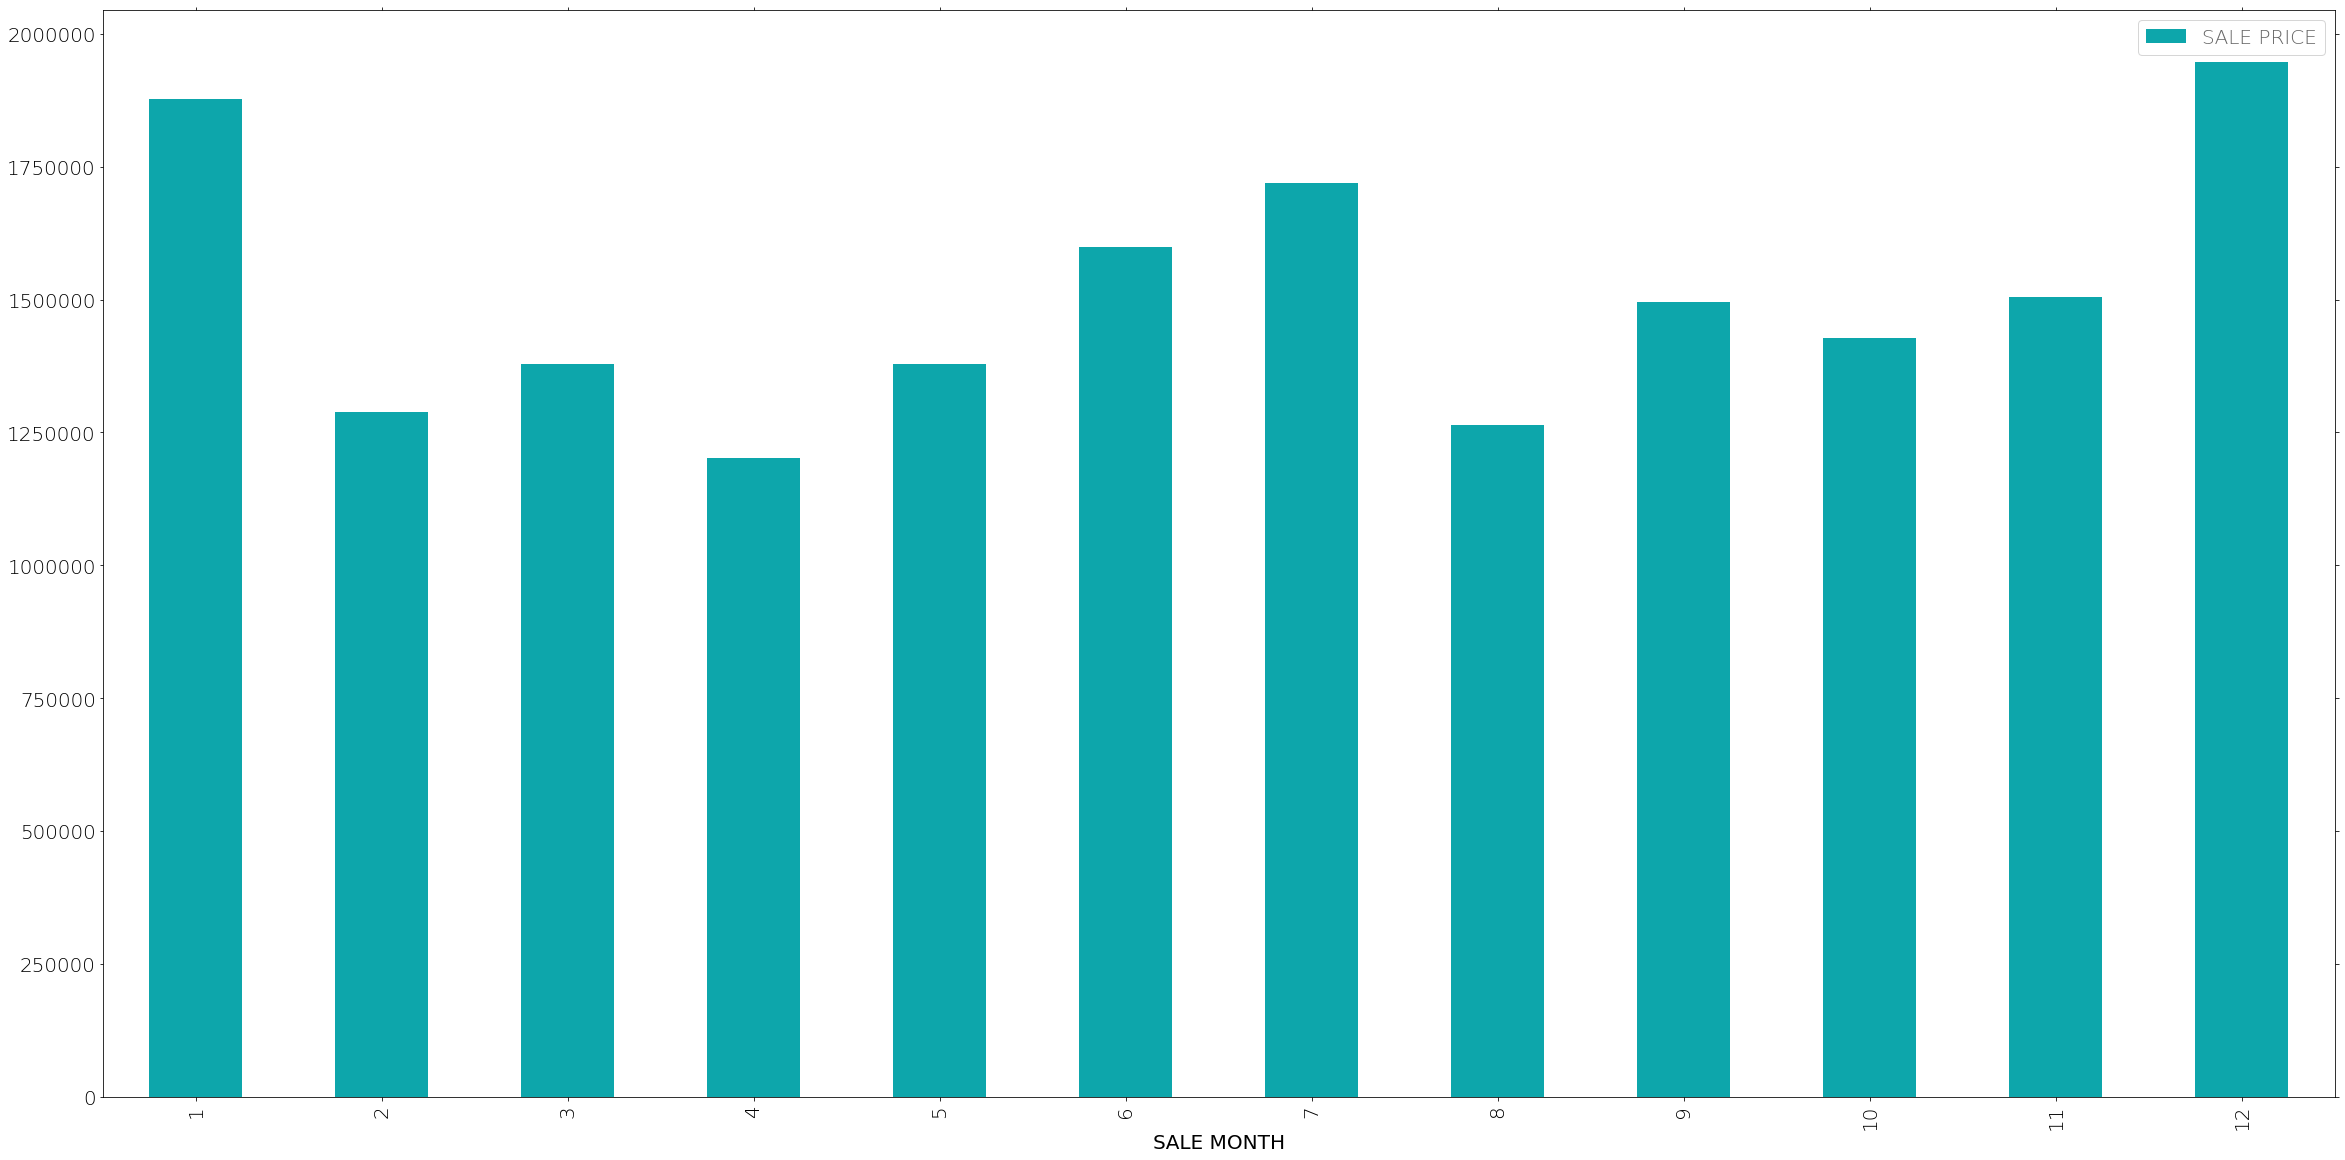

In [22]:
month_ave = df[['SALE MONTH', 'SALE PRICE']].groupby("SALE MONTH").mean()

month_ave.plot.bar(color=(0.05, 0.65, 0.67, 1));

In [ ]:
monthyear_sum = df[['SALE YEAR AND MONTH', 'SALE PRICE']].groupby("SALE YEAR AND MONTH").sum()

monthyear_sum.plot(color=(0.05, 0.65, 0.67, 1));

In [ ]:
monthyear_count = df[['SALE YEAR AND MONTH', 'SALE PRICE']].groupby("SALE YEAR AND MONTH").count()

monthyear_count.plot(color=(0.05, 0.65, 0.67, 1));

### Average over time (grouped by month and year)

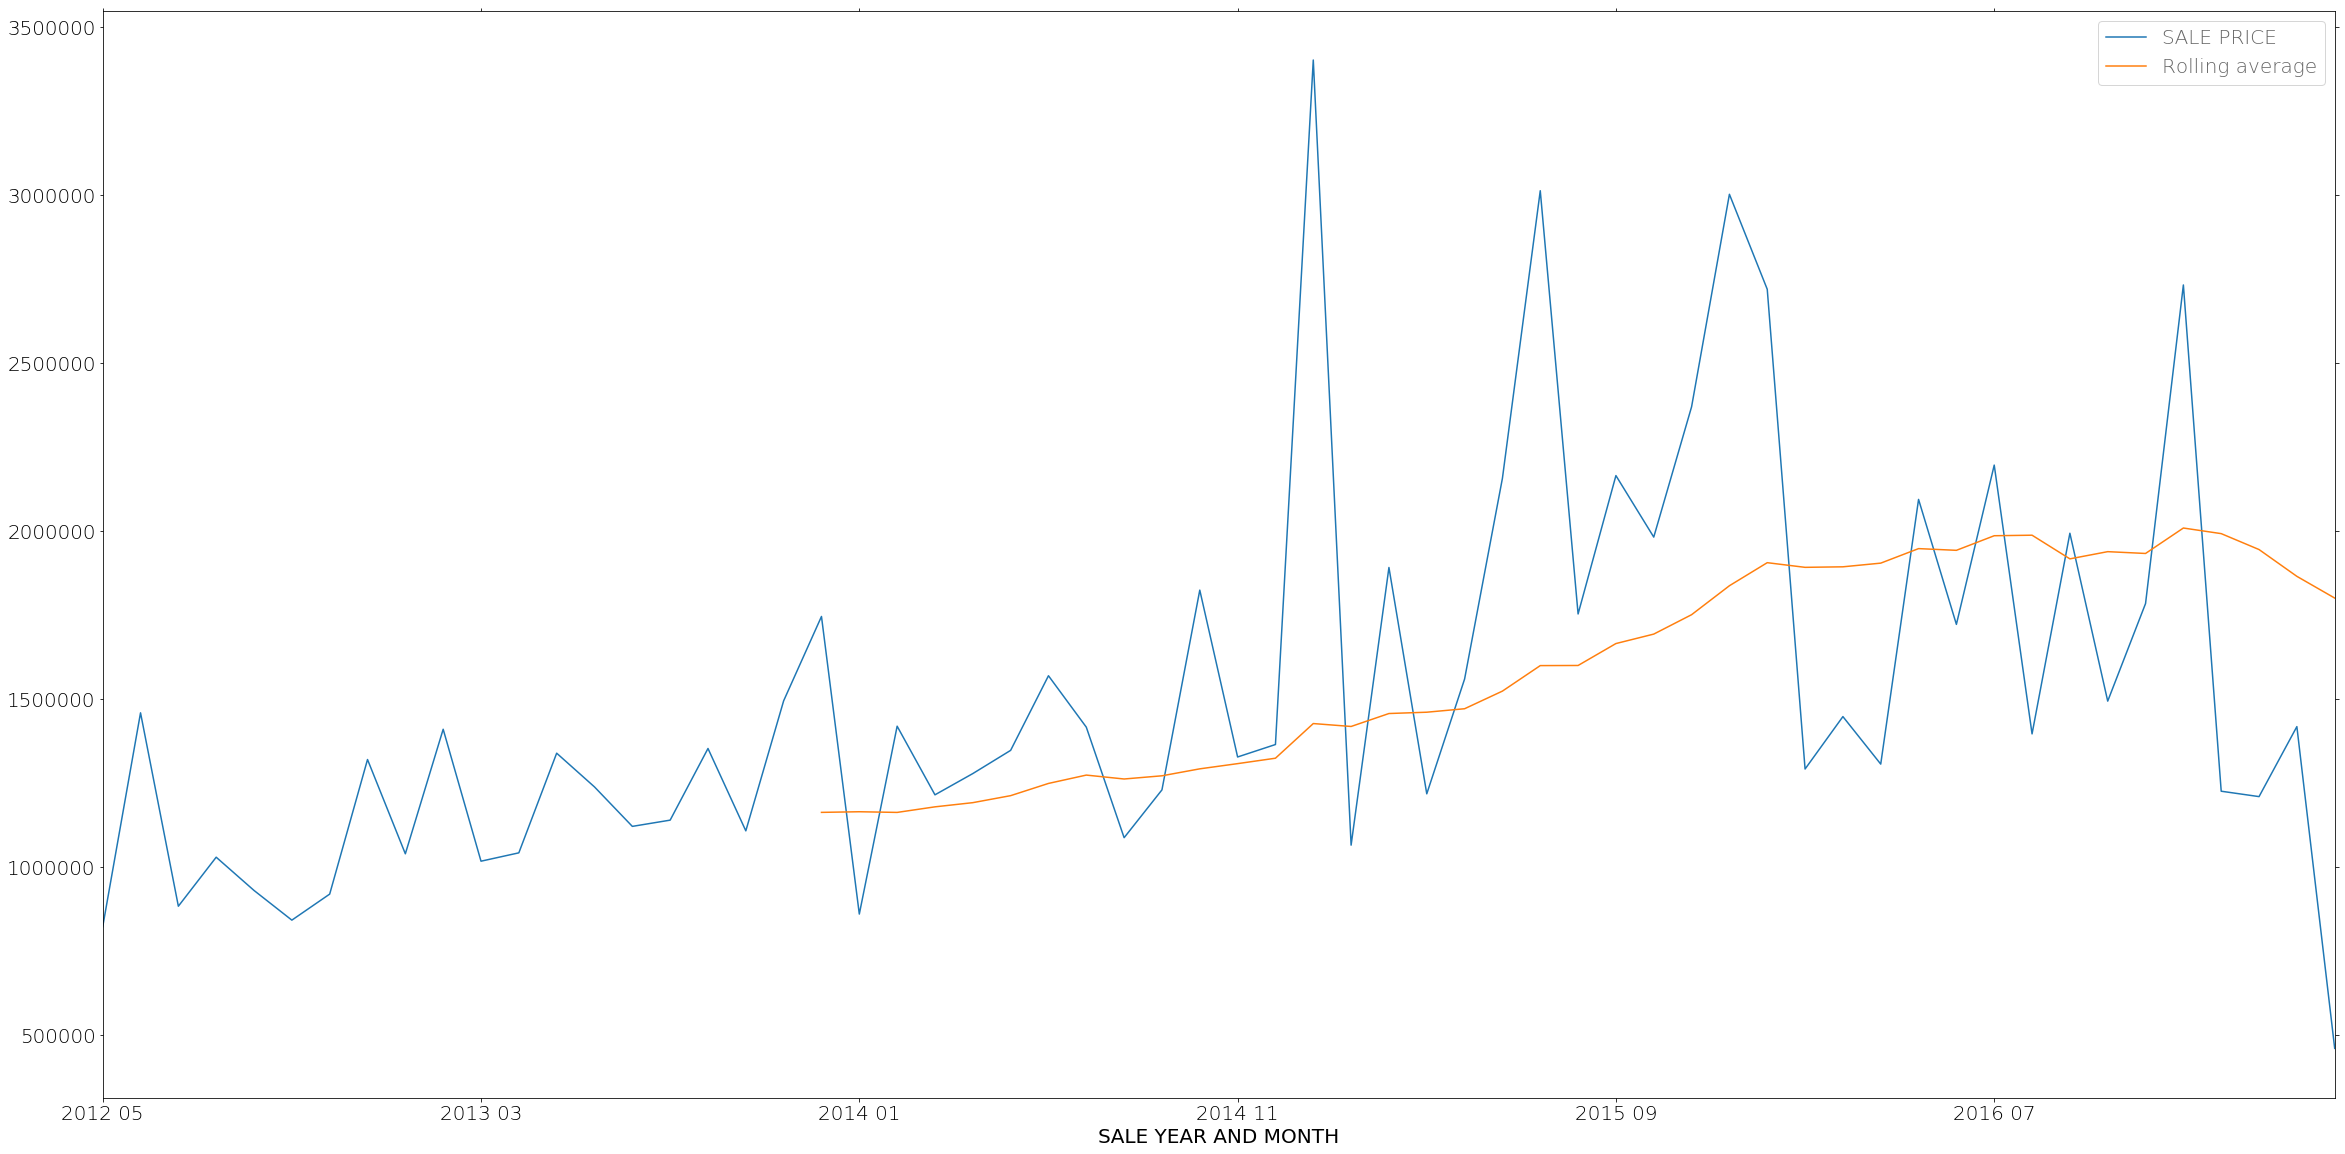

In [23]:
monthyear_ave = df[['SALE YEAR AND MONTH', 'SALE PRICE']].groupby("SALE YEAR AND MONTH").mean()

monthyear_ave['Rolling average'] = monthyear_ave['SALE PRICE'].rolling(20).mean()

monthyear_ave.plot();

## Suburbs and streets

### Average Price Per Suburb

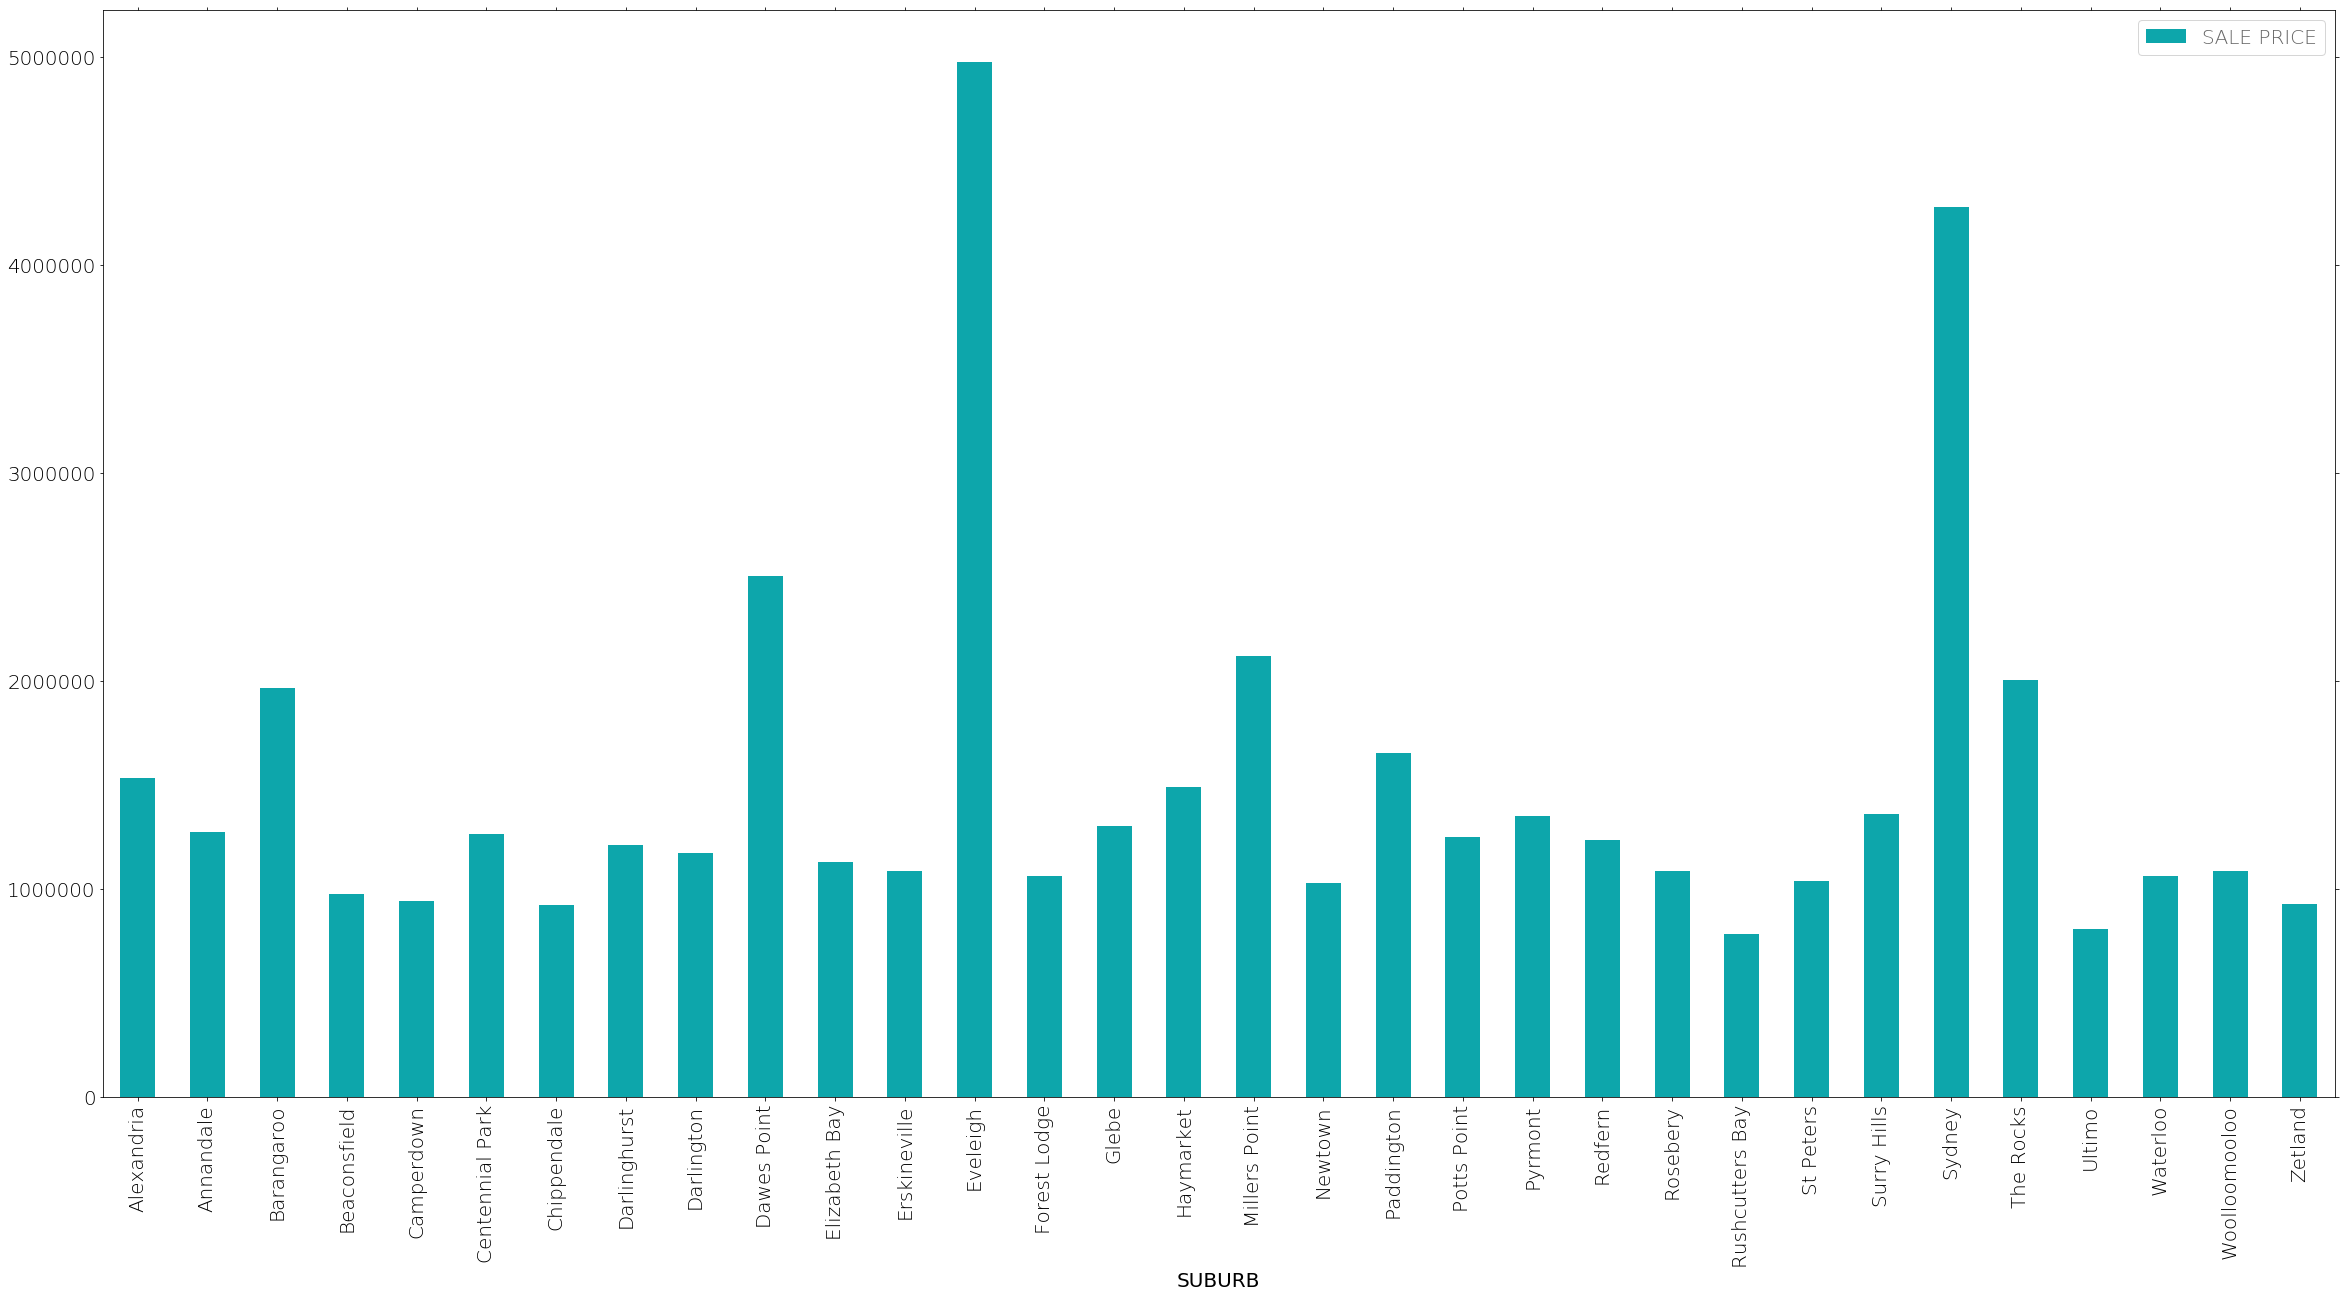

In [24]:
suburb_ave = df[["SALE PRICE", "SUBURB"]].groupby("SUBURB").mean()

suburb_ave.plot.bar(color=(0.05, 0.65, 0.67, 1));

### Average price per street type

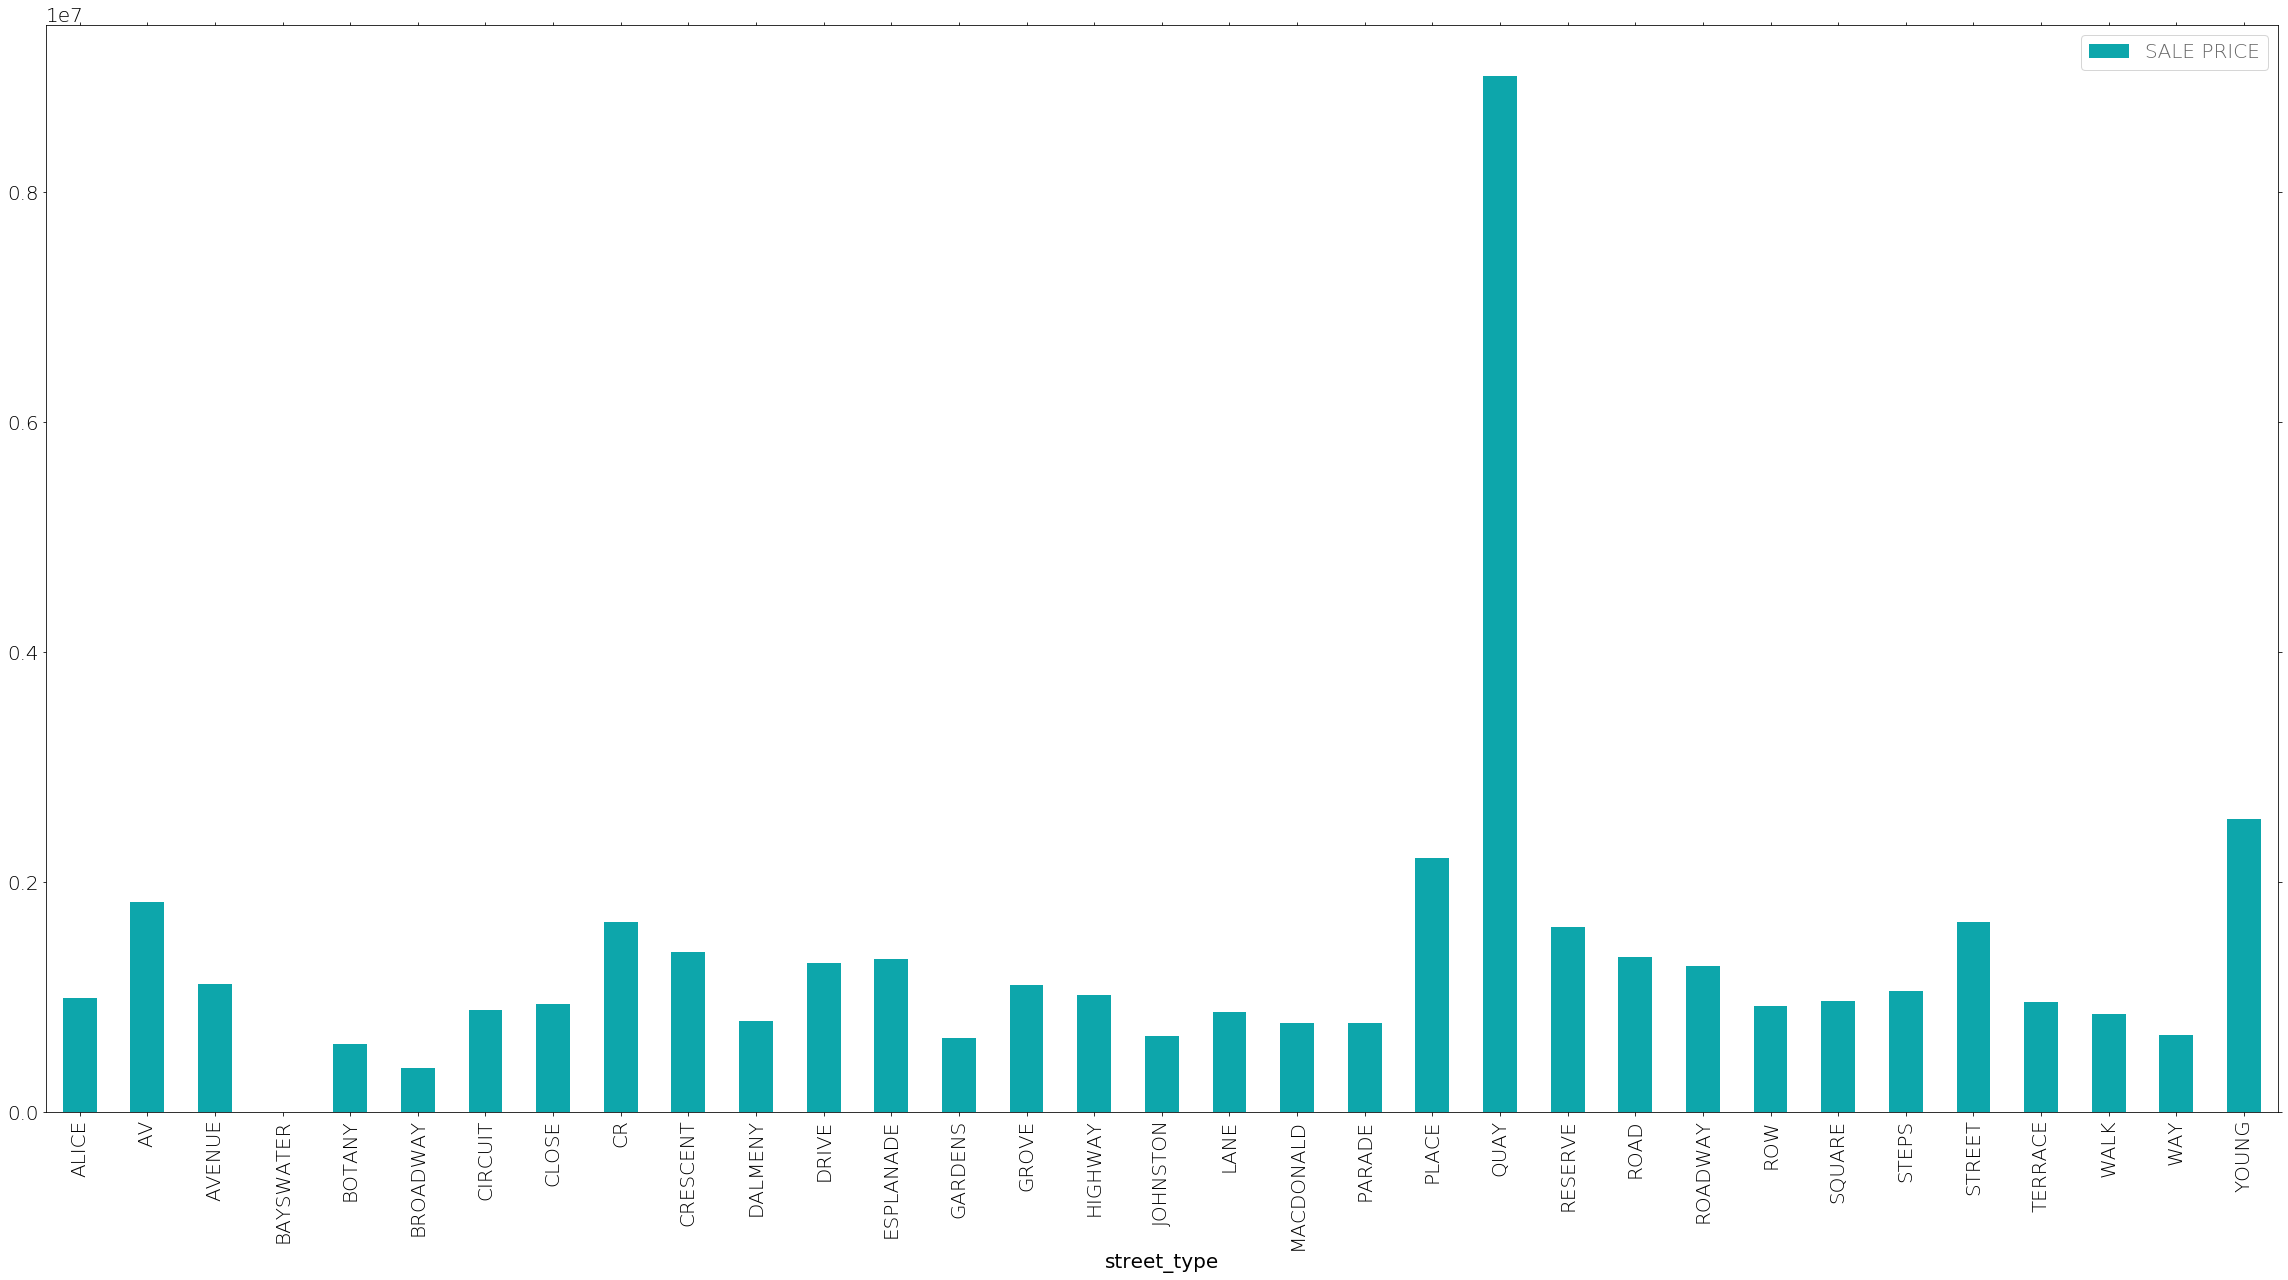

In [25]:
st_ave = df[['street_type', 'SALE PRICE']].groupby("street_type").mean()

st_ave.plot.bar(color=(0.05, 0.65, 0.67, 1));

## Area

### All (metres squared)

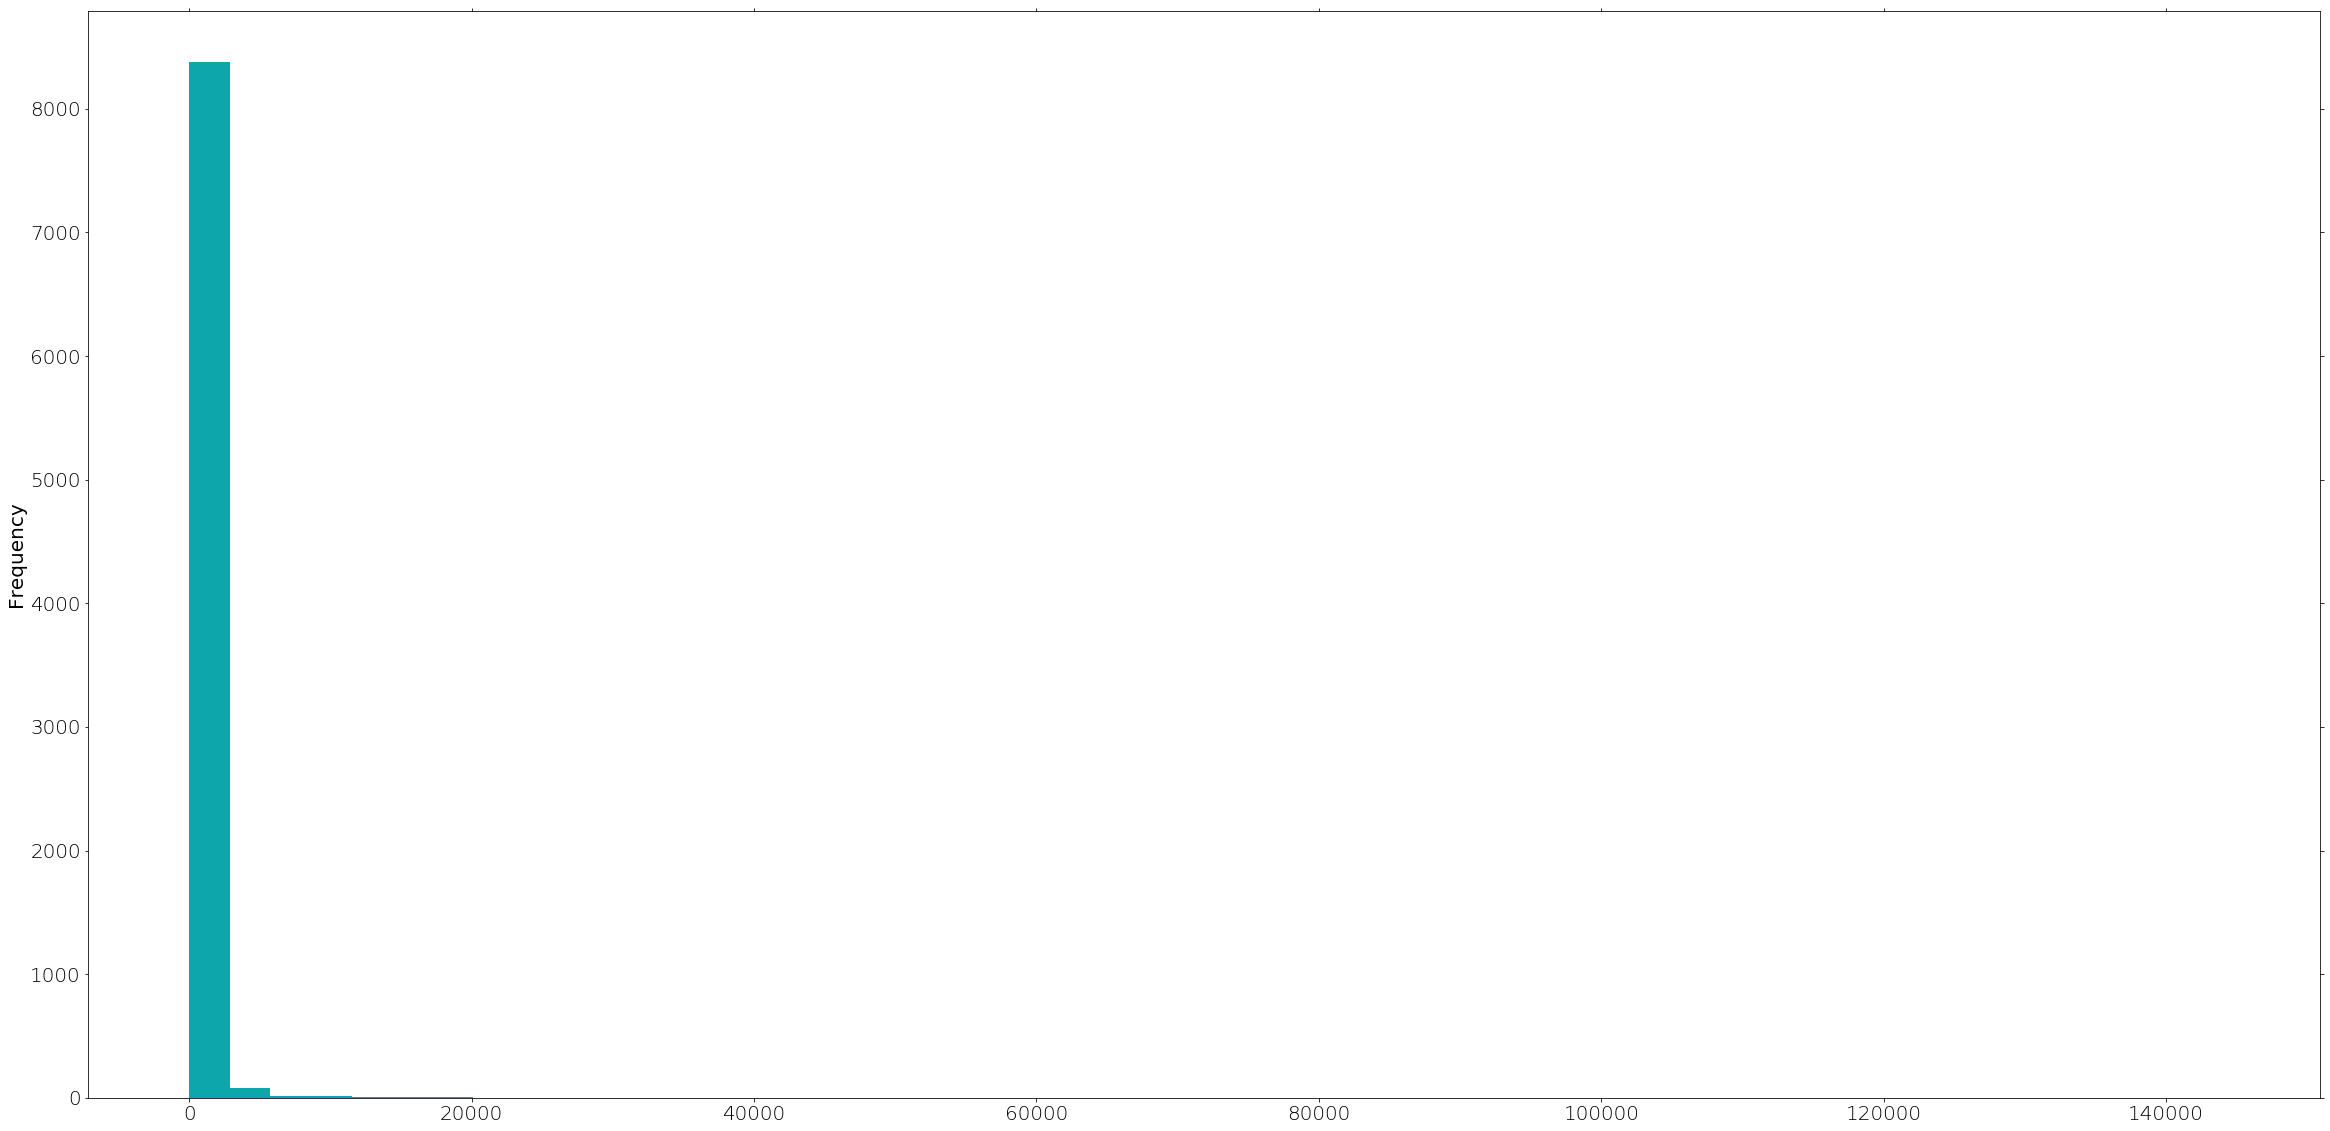

In [26]:
area = df["AREA"][non_strata_pattern]

area.plot.hist(bins=50, color=(0.05, 0.65, 0.67, 1));

### Under  500 metres squared (1 bin = 10 metres squared)

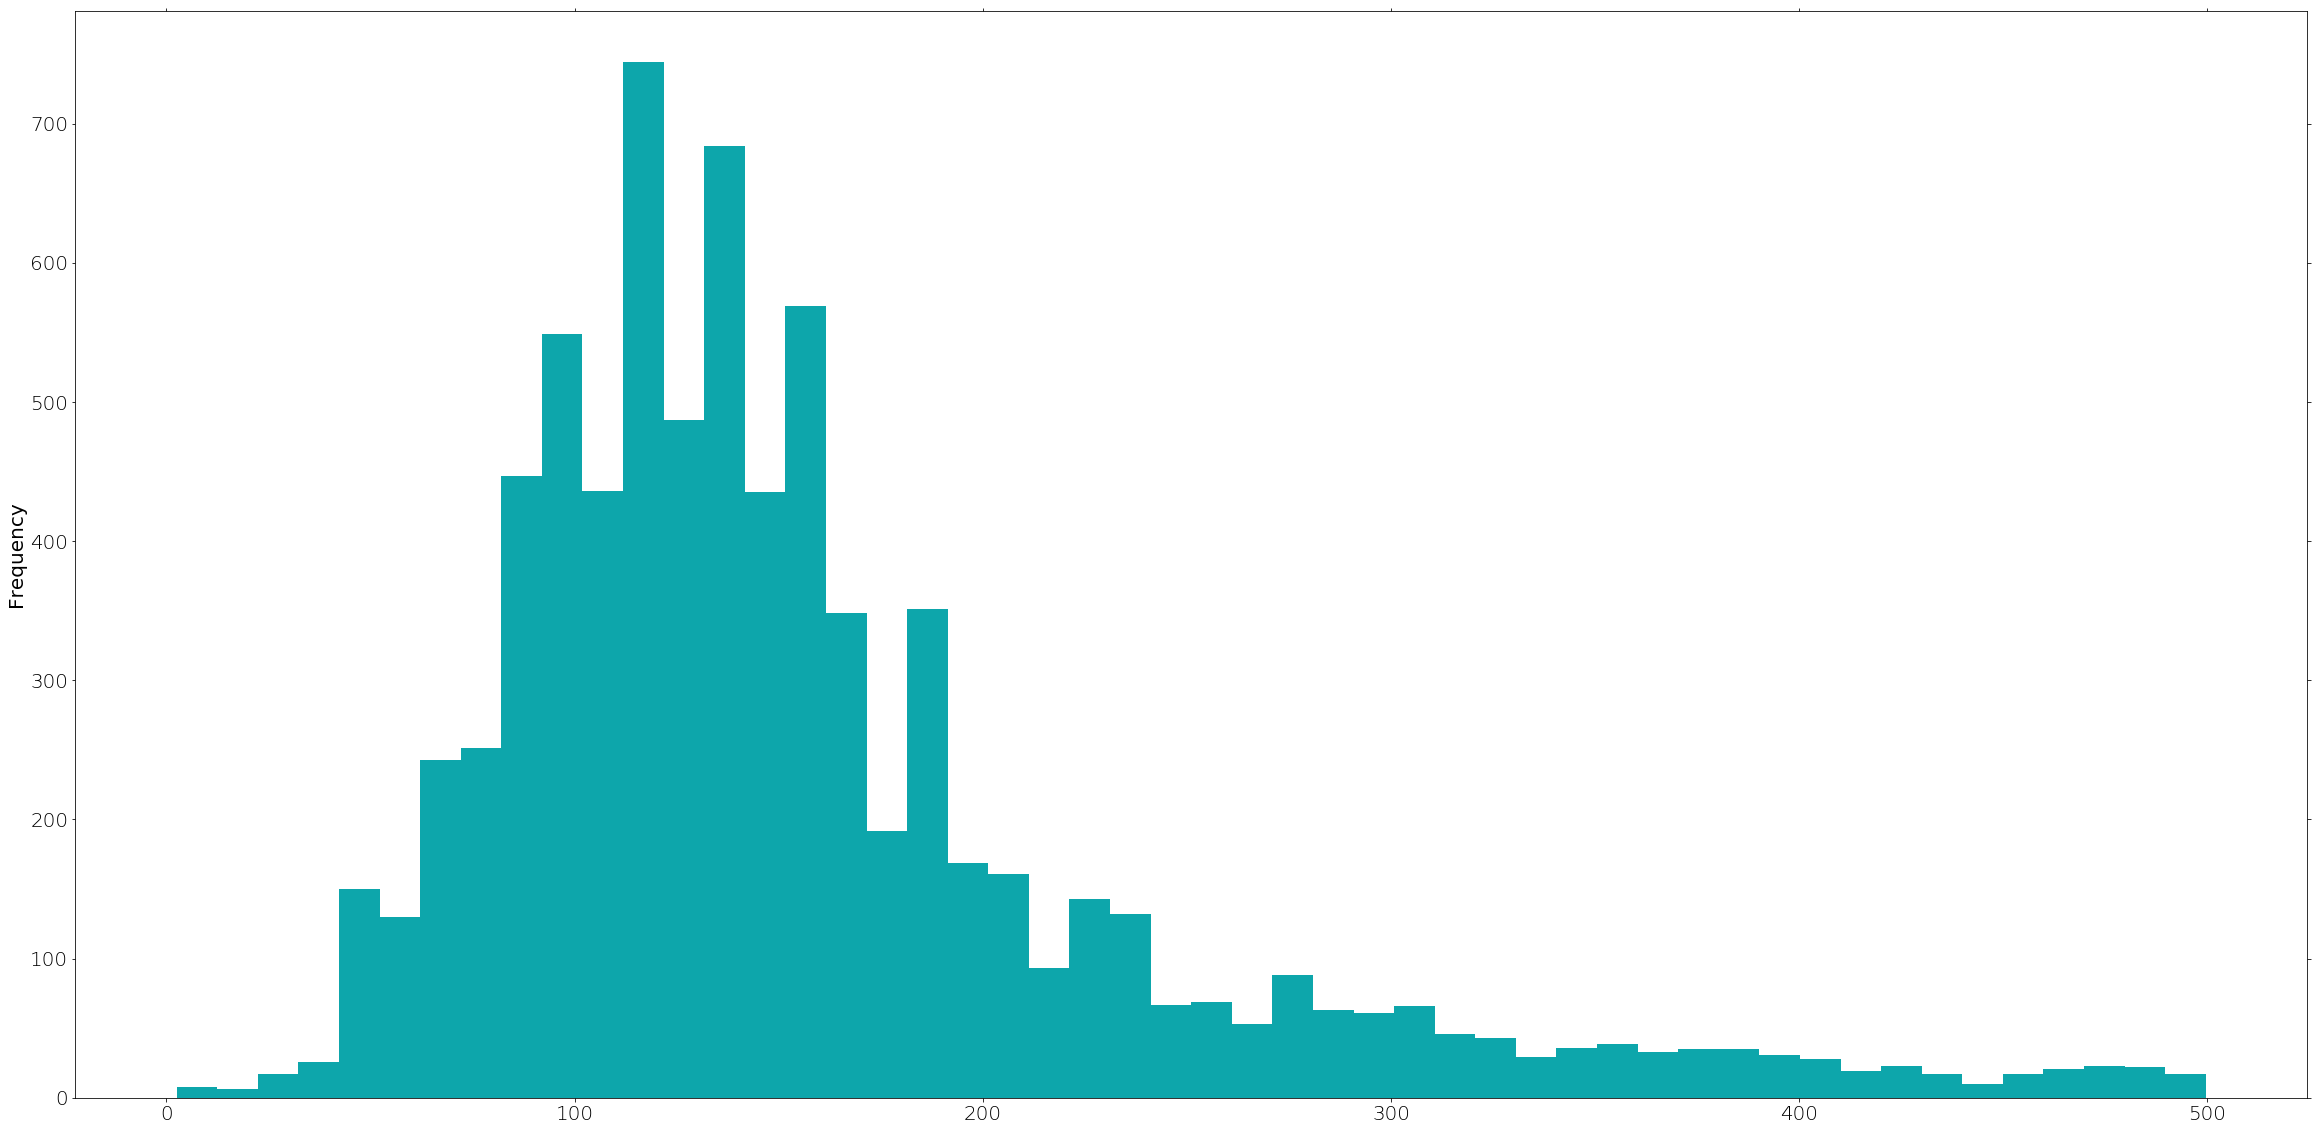

In [27]:
area = df["AREA"][non_strata_pattern][df["AREA"] <= 500]

area.plot.hist(bins=50, color=(0.05, 0.65, 0.67, 1));

### Under  500 metres squared (1 bin = 1 metre squared)

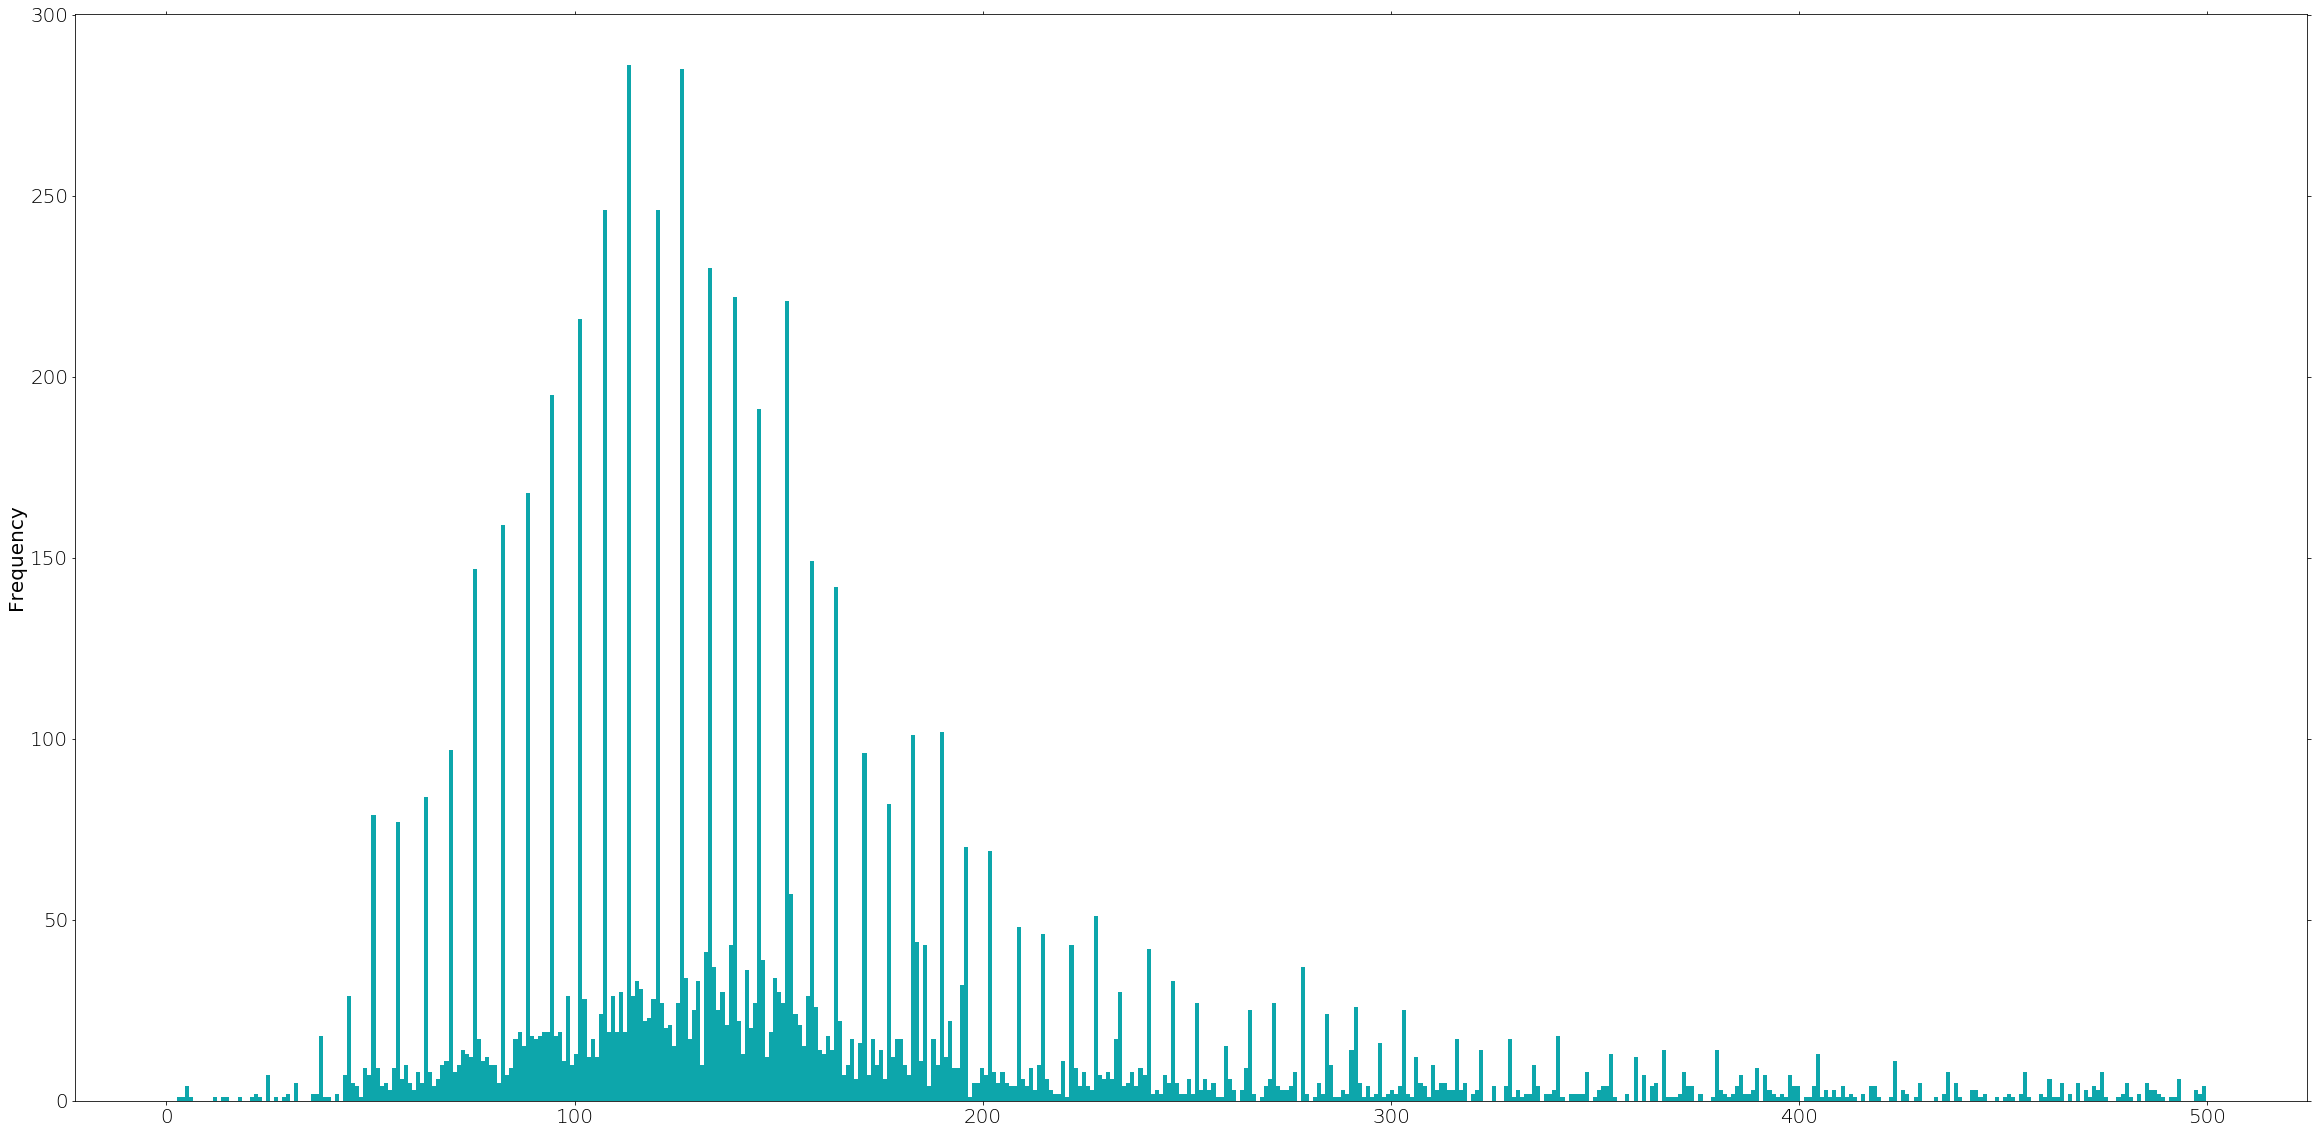

In [28]:
area = df["AREA"][non_strata_pattern][df["AREA"] <= 500]

area.plot.hist(bins=500, color=(0.05, 0.65, 0.67, 1));

### Under  500 metres squared (1 bin = 0.1 metres squared)

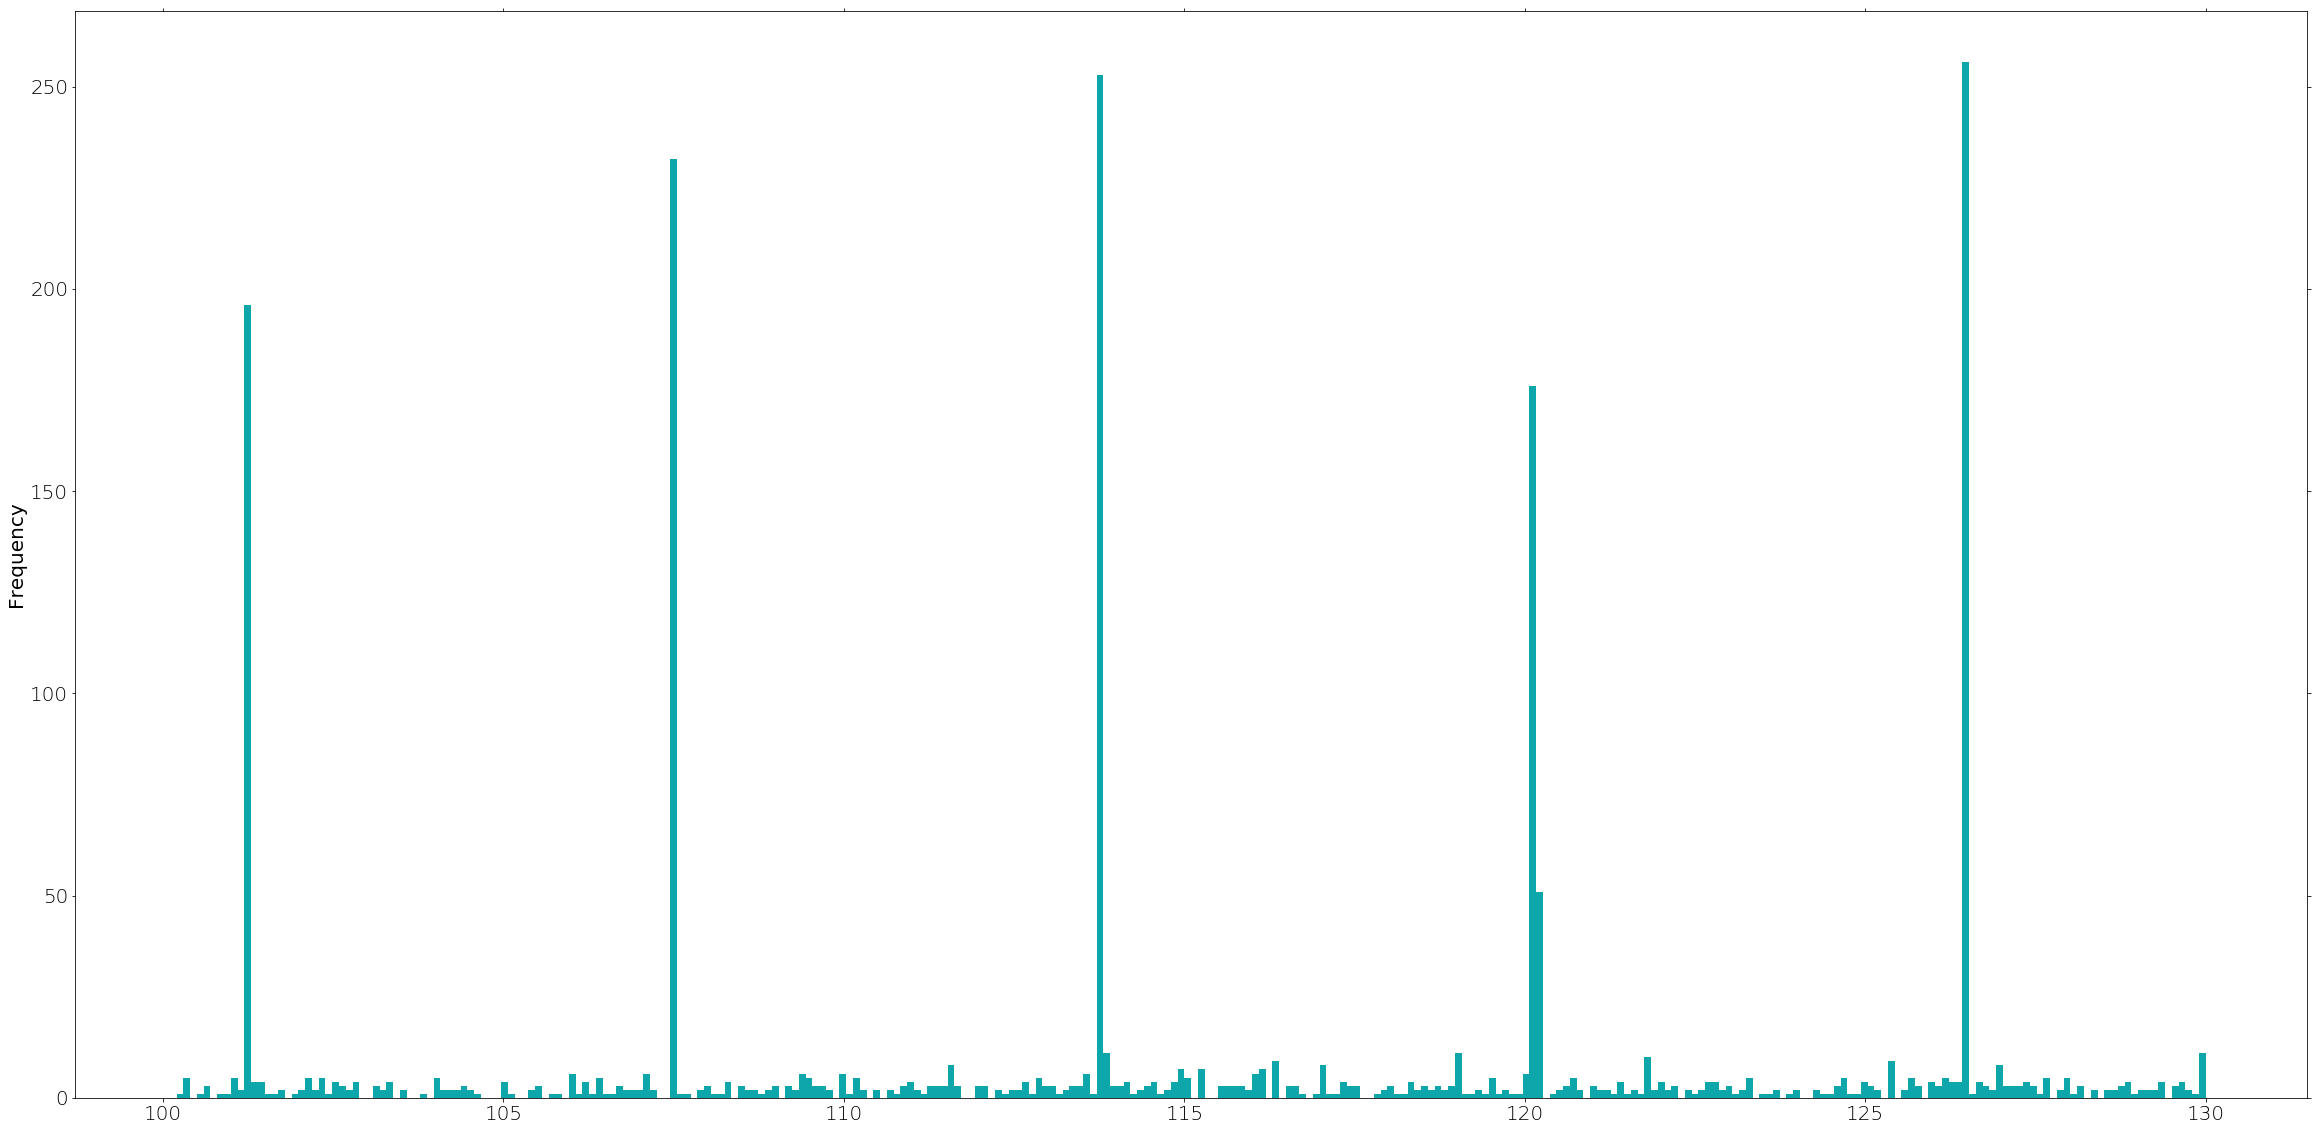

In [29]:
area = df["AREA"][non_strata_pattern][100 < df["AREA"]][df["AREA"] <= 130]

area.plot.hist(bins=300, color=(0.05, 0.65, 0.67, 1));

In [ ]:
# create geoframe

def set_latlng(x):
    lat = x['lat']
    lng = x['lng']
    xy = (lng, lat)
    return shapely.geometry.Point(xy)

df["geometry"] = df.apply(set_latlng, axis=1)

geo_df = gp.GeoDataFrame(df)

## Plotting (greater than 2 million and less than 10,000)

NameError: name 'geo_df' is not defined

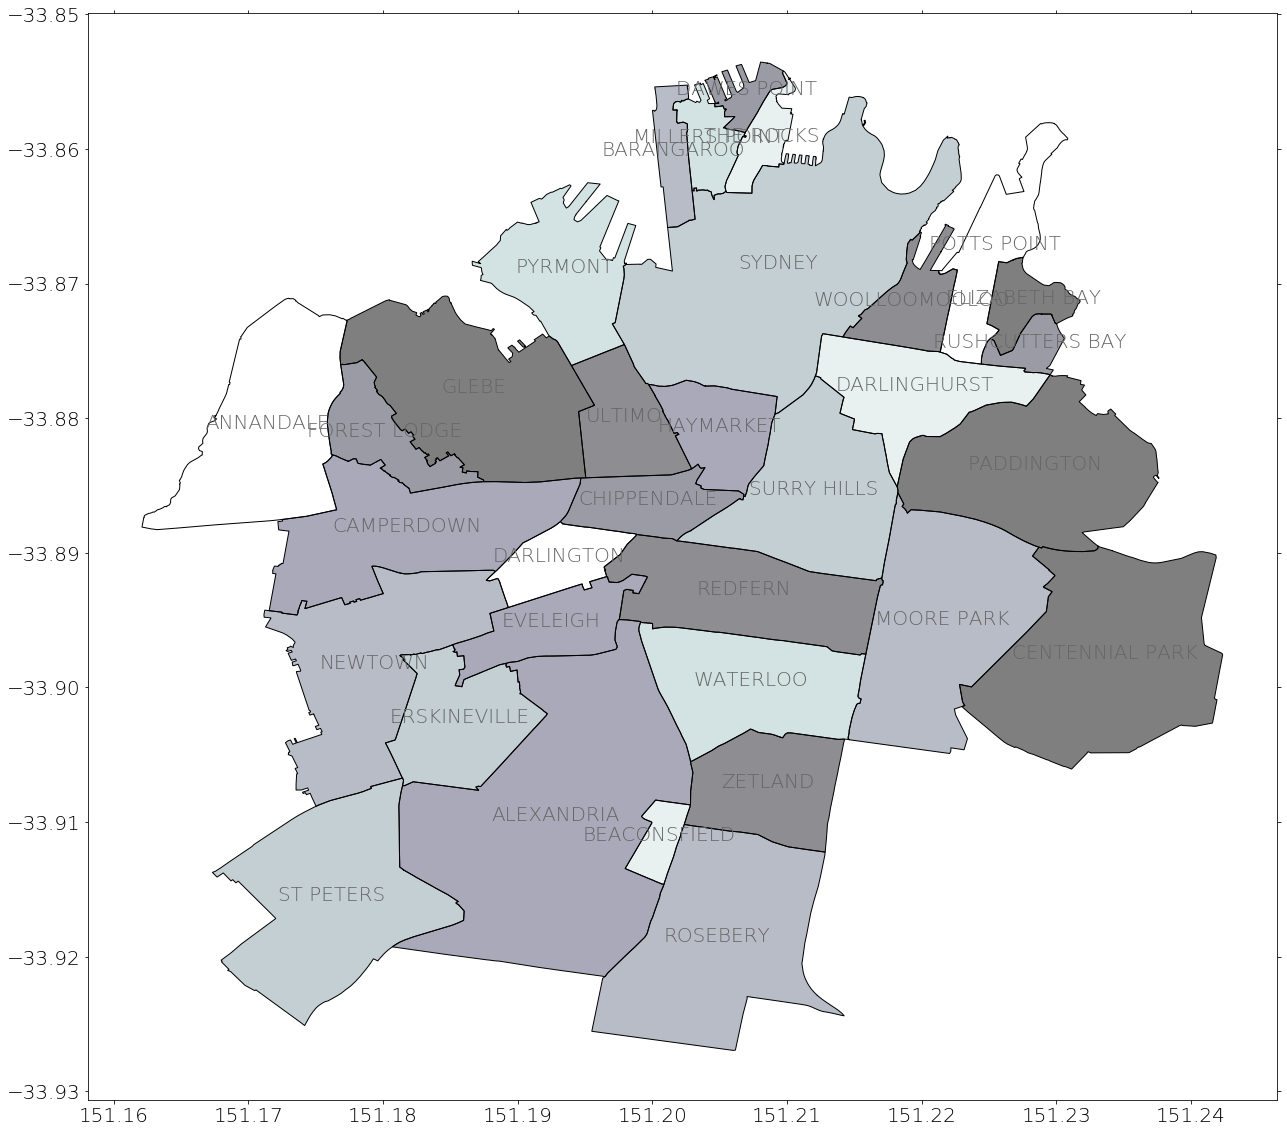

In [30]:
ax = syd_suburbs.plot(cmap='bone')


for idx, row in syd_suburbs.iterrows():
    plt.annotate(s=row.NSW_LOCA_2, 
                 xy=tuple(row.centroid.coords)[0],
                 horizontalalignment='center')
    
geo_df[df["SALE PRICE"] > 2500000].plot(ax=ax, color='red', markersize=3);
geo_df[df["SALE PRICE"] < 10000].plot(ax=ax, color='green', markersize=5);